In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import time as time
import pyarrow as pa
import dask.dataframe as dd
import dask.array as da
from dask.distributed import Client
import dask
import gc
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import bottleneck
import haversine as hs
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pygad
from multiprocessing import cpu_count
from os import sched_getaffinity
from collections import Counter
import random 
import csv
from scipy.interpolate import interp2d
from sklearn.cluster import KMeans
import warnings
from matplotlib.cm import ScalarMappable
# Suppress all warnings
warnings.filterwarnings("ignore")





In [5]:
def wind_eval(orig_height, target_height, ds, surface_roughness):
    """Takes in an xarray dataset and evaluates the wind speed magnitude at a certain height using formula, 
    then creates a new variables and assigns it to the database and replaces the original wind speed magnitude.
    Note: Sets values of wind magnitude > 25m/s to zero."""
    #creating magnitude
    ds = ds.assign(wind_mag=lambda ds: np.sqrt(ds.u100**2 + ds.v100**2))
    
    #function to adjust for height of wind turbine
    def multiply(x,surface_roughness=surface_roughness,orig_height=orig_height,target_height=target_height):
        alpha = 0.5*(surface_roughness/10)**0.2
        factor = (target_height/orig_height)**alpha
        return x*factor
        
    ds['wind_mag'] = xr.apply_ufunc(multiply, ds['wind_mag'],input_core_dims=[["longitude","latitude"]],
               output_core_dims=[["longitude", "latitude"]], dask = 'allowed', vectorize = True)
    #dropping values above 25ms-1 (cut-out speed)
    ds['wind_mag'] = ds['wind_mag'].where((ds['wind_mag']<=25) & (ds['wind_mag']>0),0, drop=False)
    ds.wind_mag.attrs["units"] = "m s**-1"
    return ds

In [6]:
#importing dataset
paths = ["/share/data1/xzcaplbl/100m_1982_to_2022_8.3MW.nc"]
ds = xr.open_mfdataset(paths, parallel=True,chunks={'latitude': -1, 'longitude': -1, 'time': -1} ,concat_dim='time', data_vars='minimal',combine='nested',coords='minimal',compat='override')

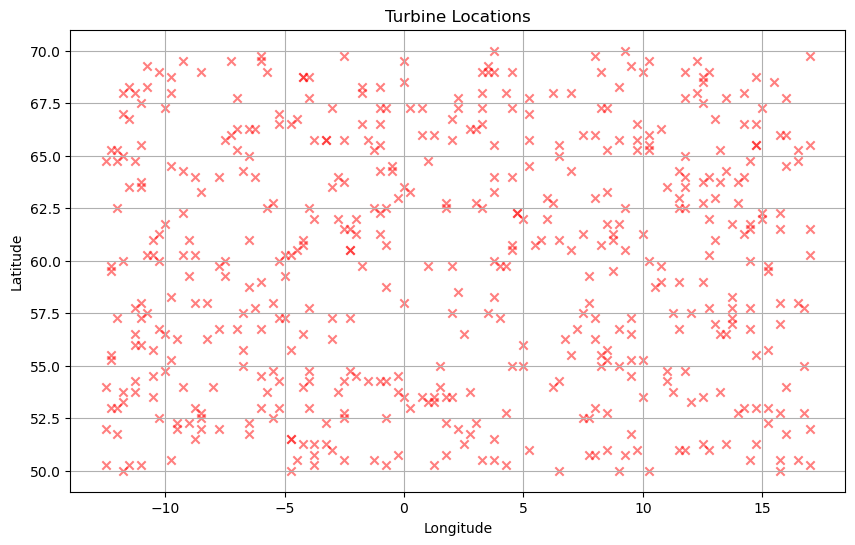

In [64]:

# Extract latitude and longitude data from the second CSV file
latitudes_2 = []
longitudes_2 = []

csv_file_path_2 = "best_coordinates1.csv"

with open(csv_file_path_2, mode='r', newline='') as file:
    reader = csv.reader(file)
    next(reader)  # Skip the header row if exists
    for row in reader:
        latitude, longitude = map(float, row)  # Convert values to float
        latitudes_2.append(latitude)
        longitudes_2.append(longitude)

# Plot both sets of coordinates together
plt.figure(figsize=(10, 6))
plt.scatter(longitudes_2, latitudes_2, marker='x', color='red', alpha=0.5)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Turbine Locations")
plt.grid(True)
plt.show()

Below is a density plot of with all the data coordiates we see above plotted in the region of Northern Europe, each grid slot is of a given size and it works to count how many coordiates from the GA have been placed in this region.

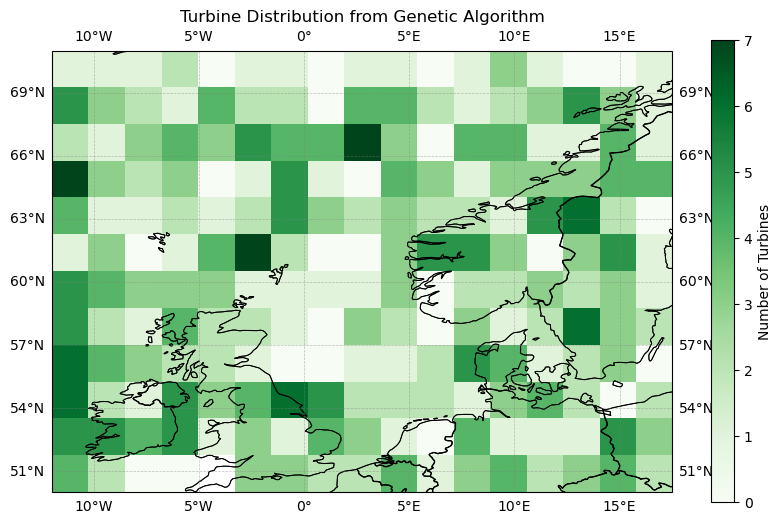

In [65]:

# Load latitude and longitude data from CSV file
latitudes_2 = []
longitudes_2 = []

csv_file_path_2 = "best_coordinates1.csv"

# Load data from CSV
with open(csv_file_path_2, mode='r', newline='') as file:
    reader = csv.reader(file)
    next(reader)  # Skip the header row if exists
    for row in reader:
        latitude, longitude = map(float, row)
        latitudes_2.append(latitude)
        longitudes_2.append(longitude)

# Define grid parameters
grid_size_lat = 1.75
grid_size_lon = 1.75
lat_min, lat_max = 50,71
lon_min, lon_max = -12,17.5

# Create latitude and longitude grid
lat_grid = np.arange(lat_min, lat_max, grid_size_lat)
lon_grid = np.arange(lon_min, lon_max, grid_size_lon)

# Count turbines in each grid cell
turbines_count = np.zeros((len(lat_grid), len(lon_grid)))
for lat, lon in zip(latitudes_2, longitudes_2):
    lat_idx = int((lat - lat_min) / grid_size_lat)
    lon_idx = int((lon - lon_min) / grid_size_lon)
    if 0 <= lat_idx < len(lat_grid) and 0 <= lon_idx < len(lon_grid):
        turbines_count[lat_idx, lon_idx] += 1

# Plot heatmap with turbine counts
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

# Define vmin and vmax for color bar
vmin = 0
vmax = 7

# Mask values outside the range for color white
masked_turbines_count = np.ma.masked_where((turbines_count < vmin) | (turbines_count > vmax), turbines_count)

plt.imshow(masked_turbines_count, extent=[lon_min, lon_max, lat_min, lat_max], origin='lower', cmap='Greens', vmin=vmin, vmax=vmax)
cbar = plt.colorbar(label='Number of Turbines')
cbar.set_ticks(np.arange(vmin, vmax+1, 1))

# Add coastline
ax.add_feature(cfeature.COASTLINE, linewidth=0.8, edgecolor='black')

# Add country borders
countries = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_0_countries',
    scale='50m',
    edgecolor='black',
    facecolor='none'
)
ax.add_feature(countries, linestyle='-', linewidth=0.5)

# Add borders to specific countries (e.g., Germany and France)
borders = cfeature.BORDERS
ax.add_feature(borders, linestyle='-', linewidth=1, edgecolor='black', facecolor='none', zorder=10)

# Add gridlines
ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
#plt.scatter(longitudes_2, latitudes_2, marker='x', color='red', alpha=0.5)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Turbine Distribution from Genetic Algorithm')
plt.show()

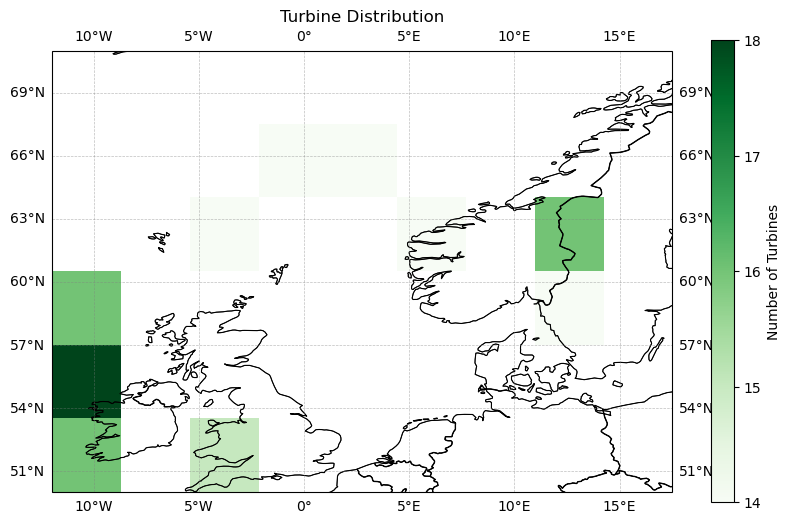

In [66]:

# Load latitude and longitude data from CSV file
latitudes_2 = []
longitudes_2 = []

csv_file_path_2 = "best_coordinates1.csv"

# Load data from CSV
with open(csv_file_path_2, mode='r', newline='') as file:
    reader = csv.reader(file)
    next(reader)  # Skip the header row if exists
    for row in reader:
        latitude, longitude = map(float, row)
        latitudes_2.append(latitude)
        longitudes_2.append(longitude)

# Define grid parameters
grid_size_lat = 3.5
grid_size_lon = 3.5
lat_min, lat_max = 50,71
lon_min, lon_max = -12,17.5

# Create latitude and longitude grid
lat_grid = np.arange(lat_min, lat_max, grid_size_lat)
lon_grid = np.arange(lon_min, lon_max, grid_size_lon)

# Count turbines in each grid cell
turbines_count = np.zeros((len(lat_grid), len(lon_grid)))
for lat, lon in zip(latitudes_2, longitudes_2):
    lat_idx = int((lat - lat_min) / grid_size_lat)
    lon_idx = int((lon - lon_min) / grid_size_lon)
    if 0 <= lat_idx < len(lat_grid) and 0 <= lon_idx < len(lon_grid):
        turbines_count[lat_idx, lon_idx] += 1

# Plot heatmap with turbine counts
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

# Define vmin and vmax for color bar
vmin = 14
vmax = 18

# Mask values outside the range for color white
masked_turbines_count = np.ma.masked_where((turbines_count < vmin) | (turbines_count > vmax), turbines_count)

plt.imshow(masked_turbines_count, extent=[lon_min, lon_max, lat_min, lat_max], origin='lower', cmap='Greens', vmin=vmin, vmax=vmax)
cbar = plt.colorbar(label='Number of Turbines')
cbar.set_ticks(np.arange(vmin, vmax+1, 1))

# Add coastline
ax.add_feature(cfeature.COASTLINE, linewidth=0.8, edgecolor='black')

# Add country borders
countries = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_0_countries',
    scale='50m',
    edgecolor='black',
    facecolor='none'
)
ax.add_feature(countries, linestyle='-', linewidth=0.5)

# Add borders to specific countries (e.g., Germany and France)
borders = cfeature.BORDERS
ax.add_feature(borders, linestyle='-', linewidth=1, edgecolor='black', facecolor='none', zorder=10)

# Add gridlines
ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
#plt.scatter(longitudes_2, latitudes_2, marker='x', color='red', alpha=0.5)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Turbine Distribution')
plt.show()

Below is the same density plot seen above, However, within a range of 5-7 per location to highlight the denser regions. 

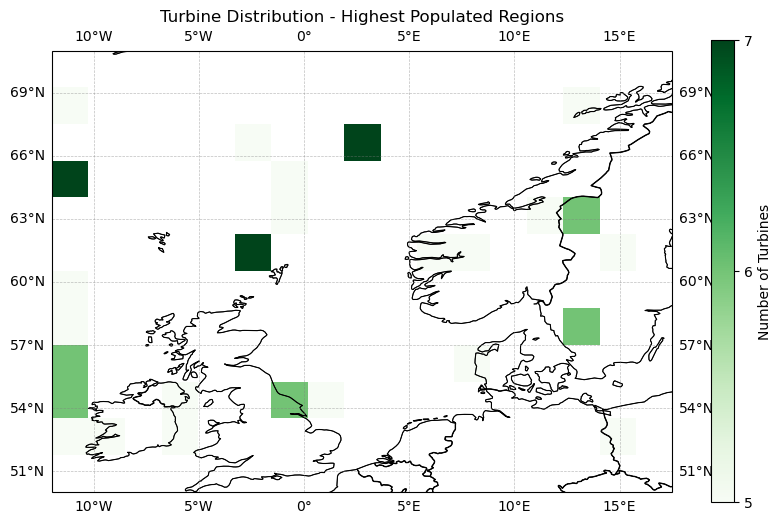

In [67]:
# Load latitude and longitude data from CSV file
latitudes_2 = []
longitudes_2 = []

csv_file_path_2 = "best_coordinates1.csv"

# Load data from CSV
with open(csv_file_path_2, mode='r', newline='') as file:
    reader = csv.reader(file)
    next(reader)  # Skip the header row if exists
    for row in reader:
        latitude, longitude = map(float, row)
        latitudes_2.append(latitude)
        longitudes_2.append(longitude)

# Define grid parameters
grid_size_lat = 1.75
grid_size_lon = 1.75
lat_min, lat_max = 50,71
lon_min, lon_max = -12,17.5

# Create latitude and longitude grid
lat_grid = np.arange(lat_min, lat_max, grid_size_lat)
lon_grid = np.arange(lon_min, lon_max, grid_size_lon)

# Count turbines in each grid cell
turbines_count = np.zeros((len(lat_grid), len(lon_grid)))
for lat, lon in zip(latitudes_2, longitudes_2):
    lat_idx = int((lat - lat_min) / grid_size_lat)
    lon_idx = int((lon - lon_min) / grid_size_lon)
    if 0 <= lat_idx < len(lat_grid) and 0 <= lon_idx < len(lon_grid):
        turbines_count[lat_idx, lon_idx] += 1

# Plot heatmap with turbine counts
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

# Define vmin and vmax for color bar
vmin = 5
vmax = 7

# Mask values outside the range for color white
masked_turbines_count = np.ma.masked_where((turbines_count < vmin) | (turbines_count > vmax), turbines_count)

plt.imshow(masked_turbines_count, extent=[lon_min, lon_max, lat_min, lat_max], origin='lower', cmap='Greens', vmin=vmin, vmax=vmax)
cbar = plt.colorbar(label='Number of Turbines')
cbar.set_ticks(np.arange(vmin, vmax+1, 1))

# Add coastline
ax.add_feature(cfeature.COASTLINE, linewidth=0.8, edgecolor='black')

# Add country borders
countries = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_0_countries',
    scale='50m',
    edgecolor='black',
    facecolor='none'
)
ax.add_feature(countries, linestyle='-', linewidth=0.5)

# Add borders to specific countries (e.g., Germany and France)
borders = cfeature.BORDERS
ax.add_feature(borders, linestyle='-', linewidth=1, edgecolor='black', facecolor='none', zorder=10)

# Add gridlines
ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
#plt.scatter(longitudes_2, latitudes_2, marker='x', color='red', alpha=0.5)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Turbine Distribution - Highest Populated Regions')
plt.show()



Below is a density plot of with the onshore coordiates removed. 

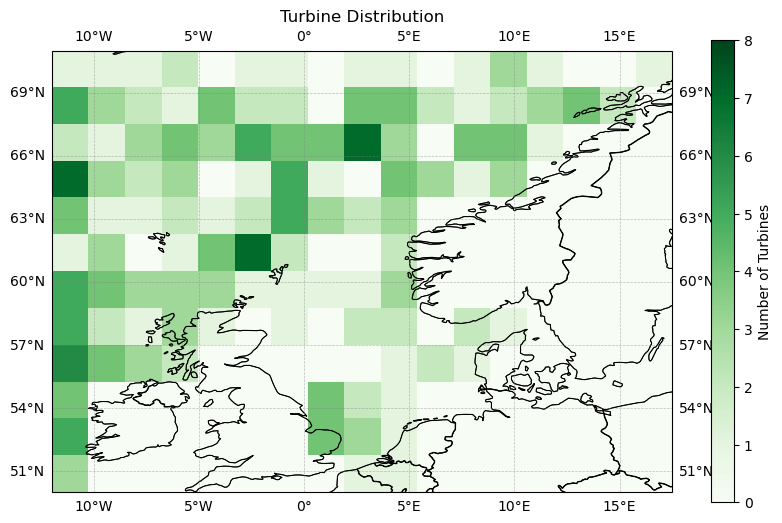

In [68]:
# Define boundaries for Scandinavia
scandinavia_boundaries = {
    'latitude_min': 58,
    'latitude_max': 68,
    'longitude_min': 13,
    'longitude_max': 17.5
}

# Define boundaries for mainland UK
uk_boundaries = {
    'latitude_min': 50,
    'latitude_max': 55,
    'longitude_min': -11,
    'longitude_max': 0
}

# Define boundaries for mainland Europe
europe_boundaries = {
    'latitude_min': 50,
    'latitude_max': 55,
    'longitude_min': 5,
    'longitude_max': 17.5
}

# Define additional boundaries for exclusion
additional_region_1_boundaries = {
    'latitude_min': 50,
    'latitude_max': 58,
    'longitude_min': 10,
    'longitude_max': 17.5
}

additional_region_2_boundaries = {
    'latitude_min': 58,
    'latitude_max': 63.5,
    'longitude_min': 5,
    'longitude_max': 17
}

additional_region_3_boundaries = {
    'latitude_min': 55,
    'latitude_max': 57.5,
    'longitude_min': -5.3,
    'longitude_max': 3.0
}

# Define additional boundaries for exclusion
additional_region_4_boundaries = {
    'latitude_min': 50,
    'latitude_max': 51,
    'longitude_min': 1,
    'longitude_max': 5
}

additional_region_5_boundaries = {
    'latitude_min': 53,
    'latitude_max': 57,
    'longitude_min': 8,
    'longitude_max': 10
}

additional_region_6_boundaries = {
    'latitude_min': 63,
    'latitude_max': 65,
    'longitude_min': 11,
    'longitude_max': 13
}

# Load latitude and longitude data from CSV file
latitudes_2 = []
longitudes_2 = []

csv_file_path_2 = "best_coordinates1.csv"

# Load data from CSV
with open(csv_file_path_2, mode='r', newline='') as file:
    reader = csv.reader(file)
    next(reader)  # Skip the header row if exists
    for row in reader:
        latitude, longitude = map(float, row)
        # Check if the coordinate falls outside specified regions
        if not ((scandinavia_boundaries['latitude_min'] <= latitude <= scandinavia_boundaries['latitude_max'] and
                scandinavia_boundaries['longitude_min'] <= longitude <= scandinavia_boundaries['longitude_max']) or
                (uk_boundaries['latitude_min'] <= latitude <= uk_boundaries['latitude_max'] and
                uk_boundaries['longitude_min'] <= longitude <= uk_boundaries['longitude_max']) or
                (europe_boundaries['latitude_min'] <= latitude <= europe_boundaries['latitude_max'] and
                europe_boundaries['longitude_min'] <= longitude <= europe_boundaries['longitude_max']) or
                (additional_region_1_boundaries['latitude_min'] <= latitude <= additional_region_1_boundaries['latitude_max'] and
                additional_region_1_boundaries['longitude_min'] <= longitude <= additional_region_1_boundaries['longitude_max']) or
                (additional_region_2_boundaries['latitude_min'] <= latitude <= additional_region_2_boundaries['latitude_max'] and
                additional_region_2_boundaries['longitude_min'] <= longitude <= additional_region_2_boundaries['longitude_max']) or
                (additional_region_3_boundaries['latitude_min'] <= latitude <= additional_region_3_boundaries['latitude_max'] and
                additional_region_3_boundaries['longitude_min'] <= longitude <= additional_region_3_boundaries['longitude_max']) or
                (additional_region_4_boundaries['latitude_min'] <= latitude <= additional_region_4_boundaries['latitude_max'] and
                additional_region_4_boundaries['longitude_min'] <= longitude <= additional_region_4_boundaries['longitude_max']) or
                (additional_region_5_boundaries['latitude_min'] <= latitude <= additional_region_5_boundaries['latitude_max'] and
                additional_region_5_boundaries['longitude_min'] <= longitude <= additional_region_5_boundaries['longitude_max']) or
                (additional_region_6_boundaries['latitude_min'] <= latitude <= additional_region_6_boundaries['latitude_max'] and
                additional_region_6_boundaries['longitude_min'] <= longitude <= additional_region_6_boundaries['longitude_max'])):
            latitudes_2.append(latitude)
            longitudes_2.append(longitude)

# Define grid parameters
grid_size_lat = 1.75
grid_size_lon = 1.75
lat_min, lat_max = 50,71 
lon_min, lon_max = -12.0,17.5

# Create latitude and longitude grid
lat_grid = np.arange(50, 71, grid_size_lat)
lon_grid = np.arange(-12, 17.5, grid_size_lon)

# Count turbines in each grid cell
turbines_count = np.zeros((len(lat_grid), len(lon_grid)))
for lat, lon in zip(latitudes_2, longitudes_2):
    lat_idx = int((lat - lat_min) / grid_size_lat)
    lon_idx = int((lon - lon_min) / grid_size_lon)
    if 0 <= lat_idx < len(lat_grid) and 0 <= lon_idx < len(lon_grid):
        turbines_count[lat_idx, lon_idx] += 1

# Plot heatmap with turbine counts
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

# Define vmin and vmax for color bar
vmin = 0
vmax = 8

# Mask values outside the range for color white
masked_turbines_count = np.ma.masked_where((turbines_count < vmin) | (turbines_count > vmax), turbines_count)

plt.imshow(masked_turbines_count, extent=[lon_min, lon_max, lat_min, lat_max], origin='lower', cmap='Greens', vmin=vmin, vmax=vmax)
cbar = plt.colorbar(label='Number of Turbines')
cbar.set_ticks(np.arange(vmin, vmax+1, 1))

# Add coastline
ax.add_feature(cfeature.COASTLINE, linewidth=0.8, edgecolor='black')

# Add country borders
countries = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_0_countries',
    scale='50m',
    edgecolor='black',
    facecolor='none'
)
ax.add_feature(countries, linestyle='-', linewidth=0.5)

# Add borders to specific countries (e.g., Germany and France)
borders = cfeature.BORDERS
ax.add_feature(borders, linestyle='-', linewidth=1, edgecolor='black', facecolor='none', zorder=10)

# Add gridlines
ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
#plt.scatter(longitudes_2, latitudes_2, marker='x', color='red', alpha=0.5)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Turbine Distribution')
plt.show()



Below is a density plot of with the onshore coordiates removed, However, within a range of 5-8 per location to highlight the denser regions. 

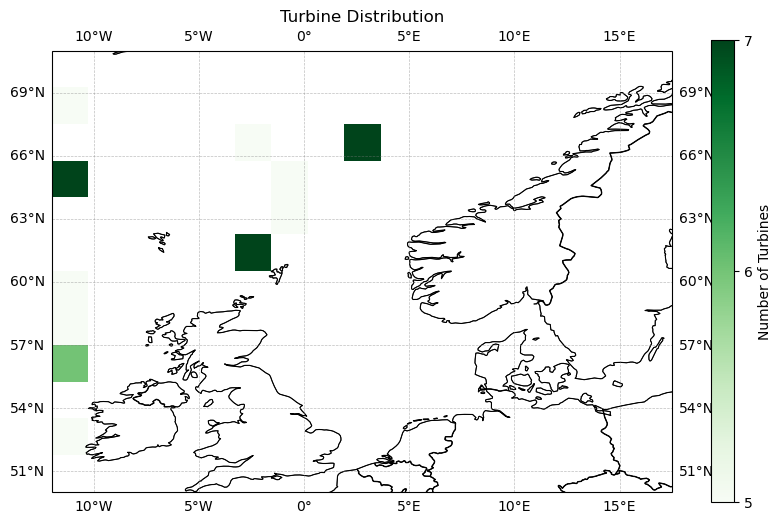

In [69]:

# Define boundaries for Scandinavia
scandinavia_boundaries = {
    'latitude_min': 58,
    'latitude_max': 68,
    'longitude_min': 13,
    'longitude_max': 17.5
}

# Define boundaries for mainland UK
uk_boundaries = {
    'latitude_min': 50,
    'latitude_max': 55,
    'longitude_min': -11,
    'longitude_max': 0
}

# Define boundaries for mainland Europe
europe_boundaries = {
    'latitude_min': 50,
    'latitude_max': 55,
    'longitude_min': 5,
    'longitude_max': 17.5
}

# Define additional boundaries for exclusion
additional_region_1_boundaries = {
    'latitude_min': 50,
    'latitude_max': 58,
    'longitude_min': 10,
    'longitude_max': 17.5
}

additional_region_2_boundaries = {
    'latitude_min': 58,
    'latitude_max': 63.5,
    'longitude_min': 5,
    'longitude_max': 17
}

additional_region_3_boundaries = {
    'latitude_min': 55,
    'latitude_max': 57.5,
    'longitude_min': -5.3,
    'longitude_max': 3.0
}

# Define additional boundaries for exclusion
additional_region_4_boundaries = {
    'latitude_min': 50,
    'latitude_max': 51,
    'longitude_min': 1,
    'longitude_max': 5
}

additional_region_5_boundaries = {
    'latitude_min': 53,
    'latitude_max': 57,
    'longitude_min': 8,
    'longitude_max': 10
}

additional_region_6_boundaries = {
    'latitude_min': 63,
    'latitude_max': 65,
    'longitude_min': 11,
    'longitude_max': 13
}

# Load latitude and longitude data from CSV file
latitudes_2 = []
longitudes_2 = []

csv_file_path_2 = "best_coordinates1.csv"

# Load data from CSV
with open(csv_file_path_2, mode='r', newline='') as file:
    reader = csv.reader(file)
    next(reader)  # Skip the header row if exists
    for row in reader:
        latitude, longitude = map(float, row)
        # Check if the coordinate falls outside specified regions
        if not ((scandinavia_boundaries['latitude_min'] <= latitude <= scandinavia_boundaries['latitude_max'] and
                scandinavia_boundaries['longitude_min'] <= longitude <= scandinavia_boundaries['longitude_max']) or
                (uk_boundaries['latitude_min'] <= latitude <= uk_boundaries['latitude_max'] and
                uk_boundaries['longitude_min'] <= longitude <= uk_boundaries['longitude_max']) or
                (europe_boundaries['latitude_min'] <= latitude <= europe_boundaries['latitude_max'] and
                europe_boundaries['longitude_min'] <= longitude <= europe_boundaries['longitude_max']) or
                (additional_region_1_boundaries['latitude_min'] <= latitude <= additional_region_1_boundaries['latitude_max'] and
                additional_region_1_boundaries['longitude_min'] <= longitude <= additional_region_1_boundaries['longitude_max']) or
                (additional_region_2_boundaries['latitude_min'] <= latitude <= additional_region_2_boundaries['latitude_max'] and
                additional_region_2_boundaries['longitude_min'] <= longitude <= additional_region_2_boundaries['longitude_max']) or
                (additional_region_3_boundaries['latitude_min'] <= latitude <= additional_region_3_boundaries['latitude_max'] and
                additional_region_3_boundaries['longitude_min'] <= longitude <= additional_region_3_boundaries['longitude_max']) or
                (additional_region_4_boundaries['latitude_min'] <= latitude <= additional_region_4_boundaries['latitude_max'] and
                additional_region_4_boundaries['longitude_min'] <= longitude <= additional_region_4_boundaries['longitude_max']) or
                (additional_region_5_boundaries['latitude_min'] <= latitude <= additional_region_5_boundaries['latitude_max'] and
                additional_region_5_boundaries['longitude_min'] <= longitude <= additional_region_5_boundaries['longitude_max']) or
                (additional_region_6_boundaries['latitude_min'] <= latitude <= additional_region_6_boundaries['latitude_max'] and
                additional_region_6_boundaries['longitude_min'] <= longitude <= additional_region_6_boundaries['longitude_max'])):
            latitudes_2.append(latitude)
            longitudes_2.append(longitude)
            
# Define grid parameters
grid_size_lat = 1.75
grid_size_lon = 1.75
lat_min, lat_max = 50,71 
lon_min, lon_max = -12.0,17.5

# Create latitude and longitude grid
lat_grid = np.arange(50, 71, grid_size_lat)
lon_grid = np.arange(-12, 17.5, grid_size_lon)

# Count turbines in each grid cell
turbines_count = np.zeros((len(lat_grid), len(lon_grid)))
for lat, lon in zip(latitudes_2, longitudes_2):
    lat_idx = int((lat - lat_min) / grid_size_lat)
    lon_idx = int((lon - lon_min) / grid_size_lon)
    if 0 <= lat_idx < len(lat_grid) and 0 <= lon_idx < len(lon_grid):
        turbines_count[lat_idx, lon_idx] += 1

# Plot heatmap with turbine counts
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

# Define vmin and vmax for color bar
vmin = 5
vmax = 7

# Mask values outside the range for color white
masked_turbines_count = np.ma.masked_where((turbines_count < vmin) | (turbines_count > vmax), turbines_count)

plt.imshow(masked_turbines_count, extent=[lon_min, lon_max, lat_min, lat_max], origin='lower', cmap='Greens', vmin=vmin, vmax=vmax)
cbar = plt.colorbar(label='Number of Turbines')
cbar.set_ticks(np.arange(vmin, vmax+1, 1))

# Add coastline
ax.add_feature(cfeature.COASTLINE, linewidth=0.8, edgecolor='black')

# Add country borders
countries = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_0_countries',
    scale='50m',
    edgecolor='black',
    facecolor='none'
)
ax.add_feature(countries, linestyle='-', linewidth=0.5)

# Add borders to specific countries (e.g., Germany and France)
borders = cfeature.BORDERS
ax.add_feature(borders, linestyle='-', linewidth=1, edgecolor='black', facecolor='none', zorder=10)

# Add gridlines
ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
#plt.scatter(longitudes_2, latitudes_2, marker='x', color='red', alpha=0.5)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Turbine Distribution')
plt.show()




X: -11.078125, Y: 54.375
X: -0.015625, Y: 54.375
X: -11.078125, Y: 56.125
X: 12.890625, Y: 57.875
X: -1.859375, Y: 61.375
X: 12.890625, Y: 63.125
X: -11.078125, Y: 64.875
X: 3.671875, Y: 66.625


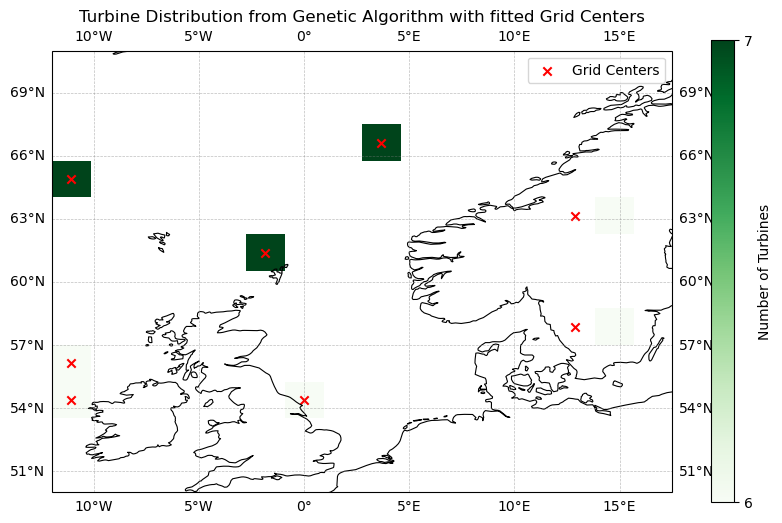

In [70]:
# Load latitude and longitude data from CSV file
latitudes_2 = []
longitudes_2 = []

csv_file_path_2 = "best_coordinates1.csv"

# Load data from CSV
with open(csv_file_path_2, mode='r', newline='') as file:
    reader = csv.reader(file)
    next(reader)  # Skip the header row if exists
    for row in reader:
        latitude, longitude = map(float, row)
        latitudes_2.append(latitude)
        longitudes_2.append(longitude)
            
# Define grid parameters
grid_size_lat = 1.75
grid_size_lon = 1.75
lat_min, lat_max = 50, 71 
lon_min, lon_max = -12.0 , 17.5

# Calculate the number of grid cells in latitude and longitude directions
num_cells_lat = int((lat_max - lat_min) / grid_size_lat)
num_cells_lon = int((lon_max - lon_min) / grid_size_lon)

# Calculate the spacing between grid centers
lat_step = (lat_max - lat_min) / num_cells_lat
lon_step = (lon_max - lon_min) / num_cells_lon

# Calculate the grid centers
grid_centers = []
for lat_idx in range(num_cells_lat):
    for lon_idx in range(num_cells_lon):
        lat_center = lat_min + lat_step * (lat_idx + 0.5)
        lon_center = lon_min + lon_step * (lon_idx + 0.5)
        grid_centers.append((lat_center, lon_center))

# Convert grid_centers to numpy array for plotting
grid_centers = np.array(grid_centers)

# Count turbines in each grid cell
turbines_count = np.zeros((num_cells_lat, num_cells_lon))
for lat, lon in zip(latitudes_2, longitudes_2):
    lat_idx = int((lat - lat_min) / grid_size_lat)
    lon_idx = int((lon - lon_min) / grid_size_lon)
    if 0 <= lat_idx < num_cells_lat and 0 <= lon_idx < num_cells_lon:
        turbines_count[lat_idx, lon_idx] += 1

# Plot heatmap with turbine counts
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

# Define vmin and vmax for color bar
vmin = 6
vmax = 7

# Mask values outside the range for color white
masked_turbines_count = np.ma.masked_where((turbines_count < vmin) | (turbines_count > vmax), turbines_count)

plt.imshow(masked_turbines_count, extent=[lon_min, lon_max, lat_min, lat_max], origin='lower', cmap='Greens', vmin=vmin, vmax=vmax)
cbar = plt.colorbar(label='Number of Turbines')
cbar.set_ticks(np.arange(vmin, vmax+1, 1))

# Add coastline
ax.add_feature(cfeature.COASTLINE, linewidth=0.8, edgecolor='black')

# Add gridlines
ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')

# Filter grid centers based on turbine count
grid_centers_filtered = []
for idx, (lat, lon) in enumerate(grid_centers):
    lat_idx = int((lat - lat_min) / grid_size_lat)
    lon_idx = int((lon - lon_min) / grid_size_lon)
    if 0 <= lat_idx < num_cells_lat and 0 <= lon_idx < num_cells_lon:
        if vmin <= turbines_count[lat_idx, lon_idx] <= vmax:
            grid_centers_filtered.append((lon, lat))

# Convert filtered grid centers to numpy array for plotting
grid_centers_filtered = np.array(grid_centers_filtered)

# Plot the centers of grid cells
plt.scatter(grid_centers_filtered[:, 0], grid_centers_filtered[:, 1], color='red', marker='x', label='Grid Centers')

# Assuming grid_centers_filtered is a NumPy array
for coordinate in grid_centers_filtered:
    print(f"X: {coordinate[0]}, Y: {coordinate[1]}")



plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Turbine Distribution from Genetic Algorithm with fitted Grid Centers')
plt.legend()
plt.show()


X: -11.078125, Y: 52.625
X: -11.078125, Y: 56.125
X: -11.078125, Y: 57.875
X: -11.078125, Y: 59.625
X: -1.859375, Y: 61.375
X: -0.015625, Y: 63.125
X: -11.078125, Y: 64.875
X: -0.015625, Y: 64.875
X: -1.859375, Y: 66.625
X: 3.671875, Y: 66.625
X: -11.078125, Y: 68.375


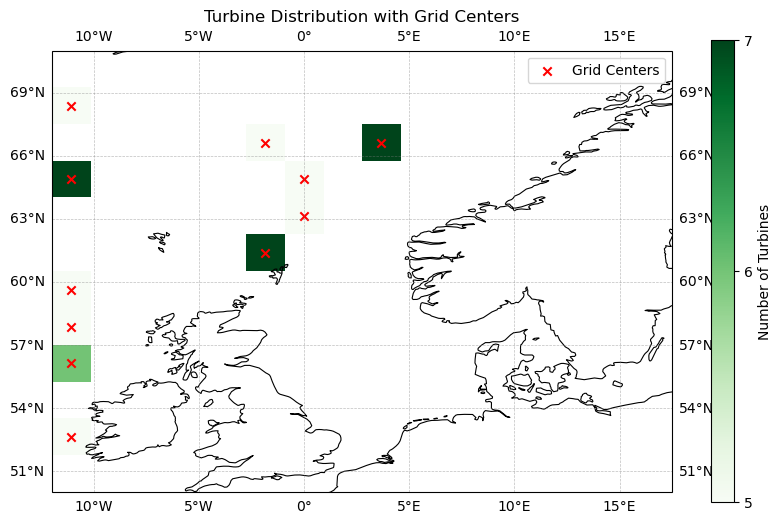

In [71]:
# Define boundaries for Scandinavia
scandinavia_boundaries = {
    'latitude_min': 58,
    'latitude_max': 68,
    'longitude_min': 13,
    'longitude_max': 17.5
}

# Define boundaries for mainland UK
uk_boundaries = {
    'latitude_min': 50,
    'latitude_max': 55,
    'longitude_min': -11,
    'longitude_max': 0
}

# Define boundaries for mainland Europe
europe_boundaries = {
    'latitude_min': 50,
    'latitude_max': 55,
    'longitude_min': 5,
    'longitude_max': 17.5
}

# Define additional boundaries for exclusion
additional_region_1_boundaries = {
    'latitude_min': 50,
    'latitude_max': 58,
    'longitude_min': 10,
    'longitude_max': 17.5
}

additional_region_2_boundaries = {
    'latitude_min': 58,
    'latitude_max': 63.5,
    'longitude_min': 5,
    'longitude_max': 17
}

additional_region_3_boundaries = {
    'latitude_min': 55,
    'latitude_max': 57.5,
    'longitude_min': -5.3,
    'longitude_max': 3.0
}

# Define additional boundaries for exclusion
additional_region_4_boundaries = {
    'latitude_min': 50,
    'latitude_max': 51,
    'longitude_min': 1,
    'longitude_max': 5
}

additional_region_5_boundaries = {
    'latitude_min': 53,
    'latitude_max': 57,
    'longitude_min': 8,
    'longitude_max': 10
}

additional_region_6_boundaries = {
    'latitude_min': 63,
    'latitude_max': 65,
    'longitude_min': 11,
    'longitude_max': 13
}

# Load latitude and longitude data from CSV file
latitudes_2 = []
longitudes_2 = []

csv_file_path_2 = "best_coordinates1.csv"

# Load data from CSV
with open(csv_file_path_2, mode='r', newline='') as file:
    reader = csv.reader(file)
    next(reader)  # Skip the header row if exists
    for row in reader:
        latitude, longitude = map(float, row)
        # Check if the coordinate falls outside specified regions
        if not (
            (scandinavia_boundaries['latitude_min'] <= latitude <= scandinavia_boundaries['latitude_max'] and
            scandinavia_boundaries['longitude_min'] <= longitude <= scandinavia_boundaries['longitude_max']) or
            (uk_boundaries['latitude_min'] <= latitude <= uk_boundaries['latitude_max'] and
            uk_boundaries['longitude_min'] <= longitude <= uk_boundaries['longitude_max']) or
            (europe_boundaries['latitude_min'] <= latitude <= europe_boundaries['latitude_max'] and
            europe_boundaries['longitude_min'] <= longitude <= europe_boundaries['longitude_max']) or
            (additional_region_1_boundaries['latitude_min'] <= latitude <= additional_region_1_boundaries['latitude_max'] and
            additional_region_1_boundaries['longitude_min'] <= longitude <= additional_region_1_boundaries['longitude_max']) or
            (additional_region_2_boundaries['latitude_min'] <= latitude <= additional_region_2_boundaries['latitude_max'] and
            additional_region_2_boundaries['longitude_min'] <= longitude <= additional_region_2_boundaries['longitude_max']) or
            (additional_region_3_boundaries['latitude_min'] <= latitude <= additional_region_3_boundaries['latitude_max'] and
            additional_region_3_boundaries['longitude_min'] <= longitude <= additional_region_3_boundaries['longitude_max']) or
            (additional_region_4_boundaries['latitude_min'] <= latitude <= additional_region_4_boundaries['latitude_max'] and
            additional_region_4_boundaries['longitude_min'] <= longitude <= additional_region_4_boundaries['longitude_max']) or
            (additional_region_5_boundaries['latitude_min'] <= latitude <= additional_region_5_boundaries['latitude_max'] and
            additional_region_5_boundaries['longitude_min'] <= longitude <= additional_region_5_boundaries['longitude_max']) or
            (additional_region_6_boundaries['latitude_min'] <= latitude <= additional_region_6_boundaries['latitude_max'] and
            additional_region_6_boundaries['longitude_min'] <= longitude <= additional_region_6_boundaries['longitude_max'])
        ):
            latitudes_2.append(latitude)
            longitudes_2.append(longitude)
            
            
# Define grid parameters
grid_size_lat = 1.75
grid_size_lon = 1.75
lat_min, lat_max = 50, 71 
lon_min, lon_max = -12.0 , 17.5

# Calculate the number of grid cells in latitude and longitude directions
num_cells_lat = int((lat_max - lat_min) / grid_size_lat)
num_cells_lon = int((lon_max - lon_min) / grid_size_lon)

# Calculate the spacing between grid centers
lat_step = (lat_max - lat_min) / num_cells_lat
lon_step = (lon_max - lon_min) / num_cells_lon

# Calculate the grid centers
grid_centers = []
for lat_idx in range(num_cells_lat):
    for lon_idx in range(num_cells_lon):
        lat_center = lat_min + lat_step * (lat_idx + 0.5)
        lon_center = lon_min + lon_step * (lon_idx + 0.5)
        grid_centers.append((lat_center, lon_center))

# Convert grid_centers to numpy array for plotting
grid_centers = np.array(grid_centers)

# Count turbines in each grid cell
turbines_count = np.zeros((num_cells_lat, num_cells_lon))
for lat, lon in zip(latitudes_2, longitudes_2):
    lat_idx = int((lat - lat_min) / grid_size_lat)
    lon_idx = int((lon - lon_min) / grid_size_lon)
    if 0 <= lat_idx < num_cells_lat and 0 <= lon_idx < num_cells_lon:
        turbines_count[lat_idx, lon_idx] += 1

# Plot heatmap with turbine counts
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

# Define vmin and vmax for color bar
vmin = 5
vmax = 7

# Mask values outside the range for color white
masked_turbines_count = np.ma.masked_where((turbines_count < vmin) | (turbines_count > vmax), turbines_count)

plt.imshow(masked_turbines_count, extent=[lon_min, lon_max, lat_min, lat_max], origin='lower', cmap='Greens', vmin=vmin, vmax=vmax)
cbar = plt.colorbar(label='Number of Turbines')
cbar.set_ticks(np.arange(vmin, vmax+1, 1))
new_colors = cmap(np.linspace(0.3, 1, cmap.N))
cmap = plt.cm.colors.ListedColormap(new_colors)

# Add coastline
ax.add_feature(cfeature.COASTLINE, linewidth=0.8, edgecolor='black')

# Add gridlines
ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')

# Filter grid centers based on turbine count
grid_centers_filtered = []
for idx, (lat, lon) in enumerate(grid_centers):
    lat_idx = int((lat - lat_min) / grid_size_lat)
    lon_idx = int((lon - lon_min) / grid_size_lon)
    if 0 <= lat_idx < num_cells_lat and 0 <= lon_idx < num_cells_lon:
        if vmin <= turbines_count[lat_idx, lon_idx] <= vmax:
            grid_centers_filtered.append((lon, lat))

# Convert filtered grid centers to numpy array for plotting
grid_centers_filtered = np.array(grid_centers_filtered)

# Plot the centers of grid cells
plt.scatter(grid_centers_filtered[:, 0], grid_centers_filtered[:, 1], color='red', marker='x', label='Grid Centers')

# Assuming grid_centers_filtered is a NumPy array
for coordinate in grid_centers_filtered:
    print(f"X: {coordinate[0]}, Y: {coordinate[1]}")


plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Turbine Distribution with Grid Centers')
plt.legend()
plt.show()



The merged power plot from the top 5 highest populated regions, taking the central point of each region to assess how the power flucatues in the 40 year duration. 

The merged power plot from the top 5 highest populated regions, taking the central point of each region to assess how the power flucatues in the 40 year duration. However, this is the case when we have ignored the data points from onshore locations

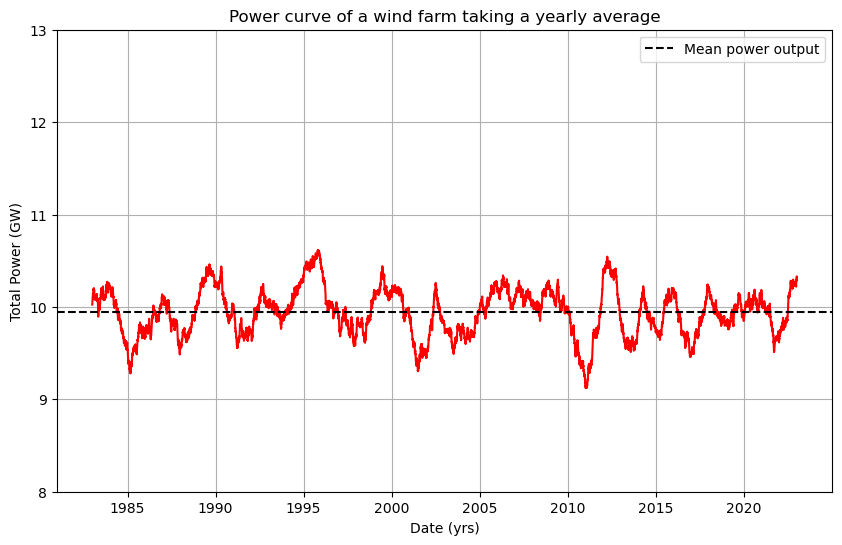

0.2554169023126073
9.940546699673197


In [8]:
####################ALL coordiates situation
coordinates_1 = [ 
    (64.75, -11.00),
    (61.25, -1.75),
    (66.75, 3.75),
    (54.25, 0.00),
    (54.25, -11.00)
]


# Initialize a variable to store the sum of power curves for the first set of turbines
total_power_curve1 = 0

# Loop through all coordinates and add the power curves together for the first set of turbines
for latitude, longitude in coordinates_1:
    power_ds_subset = ds.sel(latitude=latitude, longitude=longitude)['power']
    total_power_curve1 += power_ds_subset/(1000*1000)* 358

# Calculate the rolling average for the total power curve for the first set of turbines
rolling_avg_total1 = total_power_curve1.rolling(time=8760).mean()

mean_y_value = rolling_avg_total1.mean().values

# Plotting the total power curve and its rolling average for the first set of turbines
plt.figure(figsize=(10, 6))

plt.plot(rolling_avg_total1.time, rolling_avg_total1, color='red')
plt.axhline(y=mean_y_value, linestyle='--', label = "Mean power output", color='black')
plt.title('Power curve of a wind farm taking a yearly average')
plt.xlabel('Date (yrs)')
plt.ylabel('Total Power (GW)')
plt.ylim(8,13)
plt.legend()
plt.grid(True)
plt.show() 


# Measure the standard deviation for the second set of turbines
std_deviation1 = rolling_avg_total1.std().compute().item()  # <-- Compute the standard deviation
print(std_deviation1)
print(mean_y_value)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


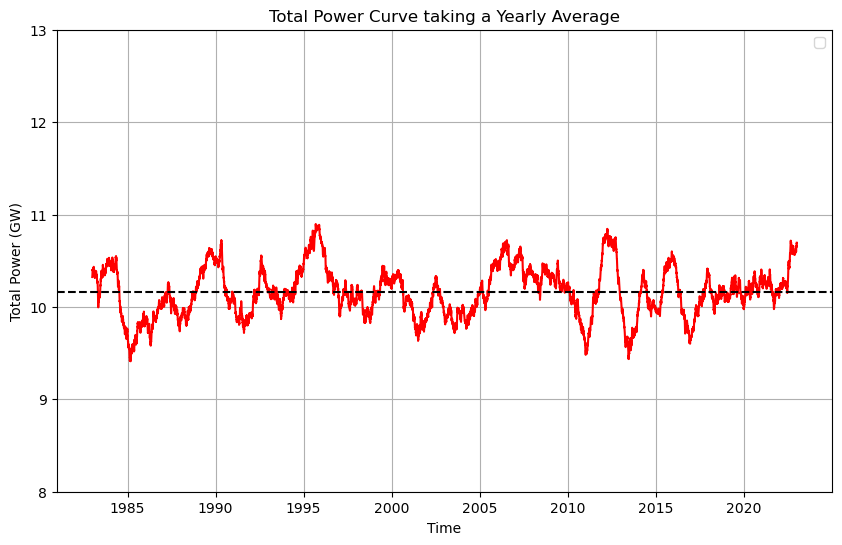

0.2708239952771305


In [73]:
#################### OFFSHORE data only


# Define the coordinates for the first set of turbines
coordinates_1 = [ 
    (64.75, -11.00),
    (61.25, -1.75),
    (66.75, 3.75),
    (66.75, -1.75),
    (56.0, -11.00)
]


# Initialize a variable to store the sum of power curves for the first set of turbines
total_power_curve1 = 0

# Loop through all coordinates and add the power curves together for the first set of turbines
for latitude, longitude in coordinates_1:
    power_ds_subset = ds.sel(latitude=latitude, longitude=longitude)['power']
    total_power_curve1 += power_ds_subset/(1000*1000)*358

    

# Calculate the rolling average for the total power curve for the first set of turbines
rolling_avg_total1 = total_power_curve1.rolling(time=8760).mean()

mean_y_value = rolling_avg_total1.mean().values

# Plotting the total power curve and its rolling average for the first set of turbines
plt.figure(figsize=(10, 6))

plt.plot(rolling_avg_total1.time, rolling_avg_total1, color='red')
plt.axhline(y=mean_y_value, linestyle='--', color='black')
plt.title('Total Power Curve taking a Yearly Average')
plt.xlabel('Time')
plt.ylabel('Total Power (GW)')
plt.ylim(8,13)
plt.legend()
plt.grid(True)
plt.show() 


# Measure the standard deviation for the second set of turbines
std_deviation1 = rolling_avg_total1.std().compute().item()  # <-- Compute the standard deviation
print(std_deviation1)

# ALL COORDINATES 


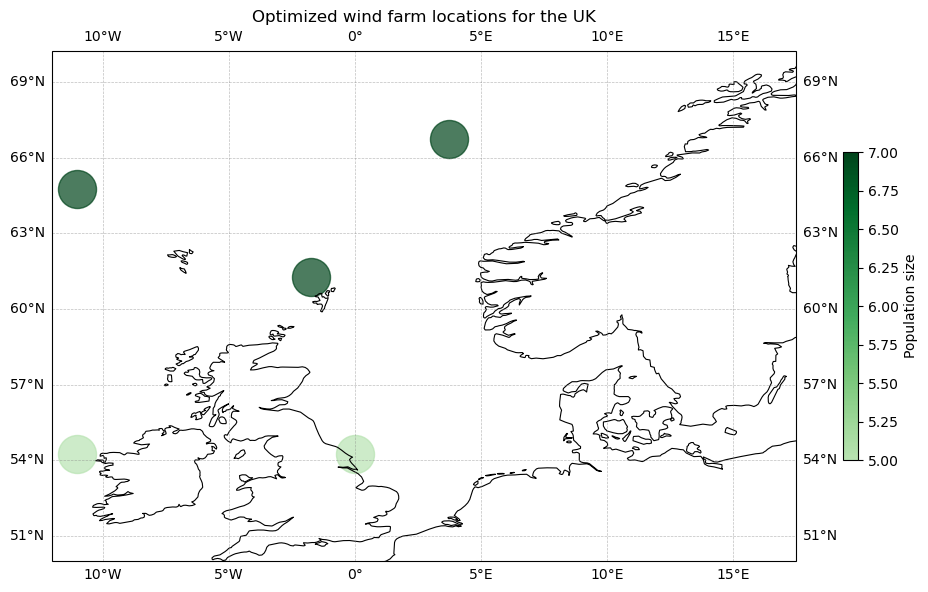

In [14]:
coordinates_1 = [ 
    (64.75, -11.00, 7),  # (latitude, longitude, weight)
    (61.25, -1.75, 7),
    (66.75, 3.75, 7),
    (54.25, -0.00, 5),
    (54.25, -11.00, 5)
]

# Extract weights
weights = [w for _, _, w in coordinates_1]
# Normalize weights
norm = plt.Normalize(min(weights), max(weights))
# Colormap
cmap = plt.cm.get_cmap('Greens')
# Adjust the colormap so that the lowest weight corresponds to a lighter shade of green
new_colors = cmap(np.linspace(0.3, 1, cmap.N))
cmap = plt.cm.colors.ListedColormap(new_colors)

# Create a map with coastlines and wind turbine locations overlay
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([-12, 17.5, 50, 70])

# Add coastlines with the cartopy.feature module
ax.add_feature(cfeature.COASTLINE, linewidth=0.8, edgecolor='black')
ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')

# Plot circles at the turbine locations with size based on weight and color based on weight
for lat, lon, weight in coordinates_1:
    ax.scatter(lon, lat, s=750, color=cmap(norm(weight)), alpha=0.7, transform=ccrs.PlateCarree())

# Create a colorbar
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', shrink=0.5)
cbar.set_label("Population size")

# Set the title
plt.title('Optimized wind farm locations for the UK')
plt.grid()

# Show the plot
plt.show()

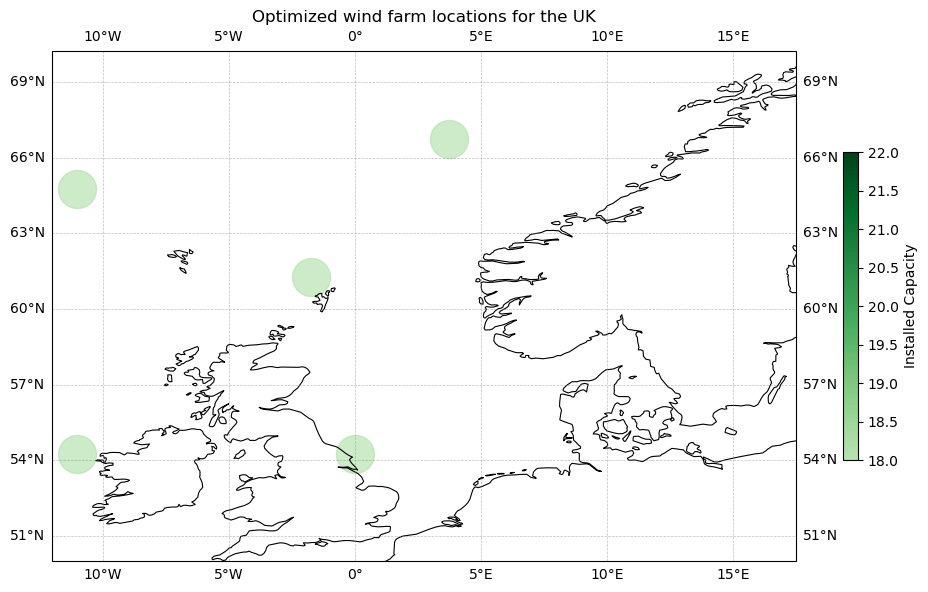

In [32]:
coordinates_1 = [ 
    (64.75, -11.00, 20),  # (latitude, longitude, weight)
    (61.25, -1.75, 20),
    (66.75, 3.75, 20),
    (54.25, -0.00, 20),
    (54.25, -11.00, 20)
]

# Extract weights
weights = [w for _, _, w in coordinates_1]
# Normalize weights
norm = plt.Normalize(min(weights), max(weights))
# Colormap
cmap = plt.cm.get_cmap('Greens')
# Adjust the colormap so that the lowest weight corresponds to a lighter shade of green
new_colors = cmap(np.linspace(0.3, 1, cmap.N))
cmap = plt.cm.colors.ListedColormap(new_colors)

# Create a map with coastlines and wind turbine locations overlay
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([-12, 17.5, 50, 70])

# Add coastlines with the cartopy.feature module
ax.add_feature(cfeature.COASTLINE, linewidth=0.8, edgecolor='black')
ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')

# Plot circles at the turbine locations with size based on weight and color based on weight
for lat, lon, weight in coordinates_1:
    ax.scatter(lon, lat, s=750, color=cmap(norm(weight)), alpha=0.7, transform=ccrs.PlateCarree())

# Create a colorbar
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', shrink=0.5)
cbar.set_label("Installed Capacity")

# Set the title
plt.title('Optimized wind farm locations for the UK')
plt.grid()

# Show the plot
plt.show()

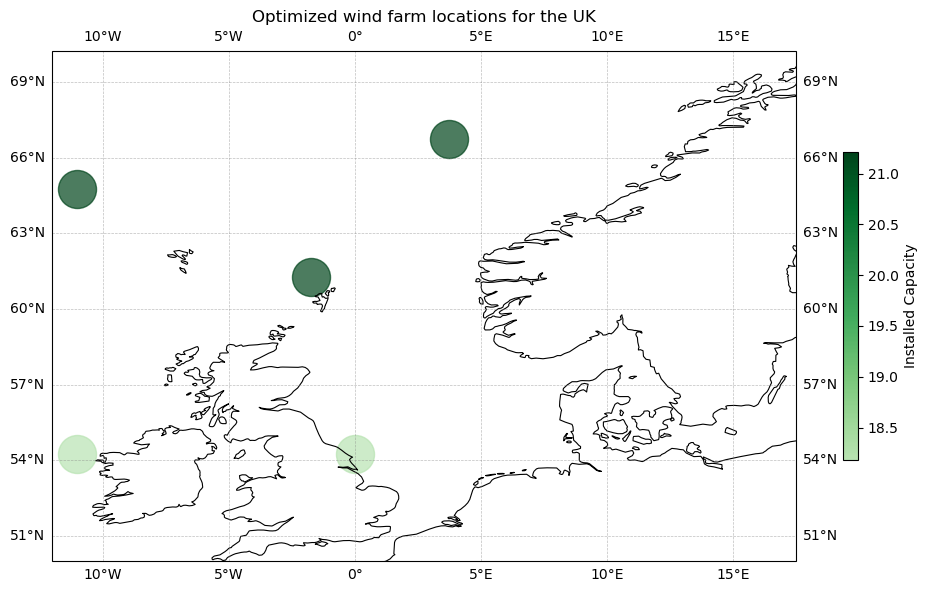

In [33]:
coordinates_1 = [ 
    (64.75, -11.00, 21.21),  # (latitude, longitude, weight)
    (61.25, -1.75, 21.21),
    (66.75, 3.75, 21.21),
    (54.25, -0.00, 18.18),
    (54.25, -11.00, 18.18)
]

# Extract weights
weights = [w for _, _, w in coordinates_1]
# Normalize weights
norm = plt.Normalize(min(weights), max(weights))
# Colormap
cmap = plt.cm.get_cmap('Greens')
# Adjust the colormap so that the lowest weight corresponds to a lighter shade of green
new_colors = cmap(np.linspace(0.3, 1, cmap.N))
cmap = plt.cm.colors.ListedColormap(new_colors)

# Create a map with coastlines and wind turbine locations overlay
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([-12, 17.5, 50, 70])

# Add coastlines with the cartopy.feature module
ax.add_feature(cfeature.COASTLINE, linewidth=0.8, edgecolor='black')
ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')

# Plot circles at the turbine locations with size based on weight and color based on weight
for lat, lon, weight in coordinates_1:
    ax.scatter(lon, lat, s=750, color=cmap(norm(weight)), alpha=0.7, transform=ccrs.PlateCarree())

# Create a colorbar
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', shrink=0.5)
cbar.set_label("Installed Capacity")

# Set the title
plt.title('Optimized wind farm locations for the UK')
plt.grid()

# Show the plot
plt.show()

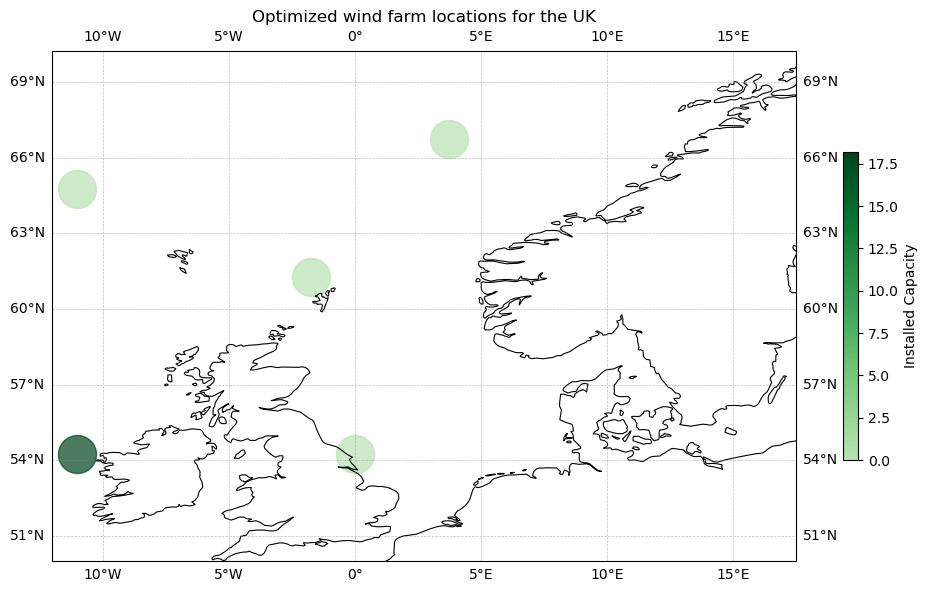

In [35]:
coordinates_1 = [ 
    (64.75, -11.00, 0),  # (latitude, longitude, weight)
    (61.25, -1.75, 0),
    (66.75, 3.75, 0),
    (54.25, -0.00, 0),
    (54.25, -11.00, 18.18)
]

# Extract weights
weights = [w for _, _, w in coordinates_1]
# Normalize weights
norm = plt.Normalize(min(weights), max(weights))
# Colormap
cmap = plt.cm.get_cmap('Greens')
# Adjust the colormap so that the lowest weight corresponds to a lighter shade of green
new_colors = cmap(np.linspace(0.3, 1, cmap.N))
cmap = plt.cm.colors.ListedColormap(new_colors)

# Create a map with coastlines and wind turbine locations overlay
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([-12, 17.5, 50, 70])

# Add coastlines with the cartopy.feature module
ax.add_feature(cfeature.COASTLINE, linewidth=0.8, edgecolor='black')
ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')

# Plot circles at the turbine locations with size based on weight and color based on weight
for lat, lon, weight in coordinates_1:
    ax.scatter(lon, lat, s=750, color=cmap(norm(weight)), alpha=0.7, transform=ccrs.PlateCarree())

# Create a colorbar
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', shrink=0.5)
cbar.set_label("Installed Capacity")

# Set the title
plt.title('Optimized wind farm locations for the UK')
plt.grid()

# Show the plot
plt.show()

# OFFSHORE ONLY COORDINATES

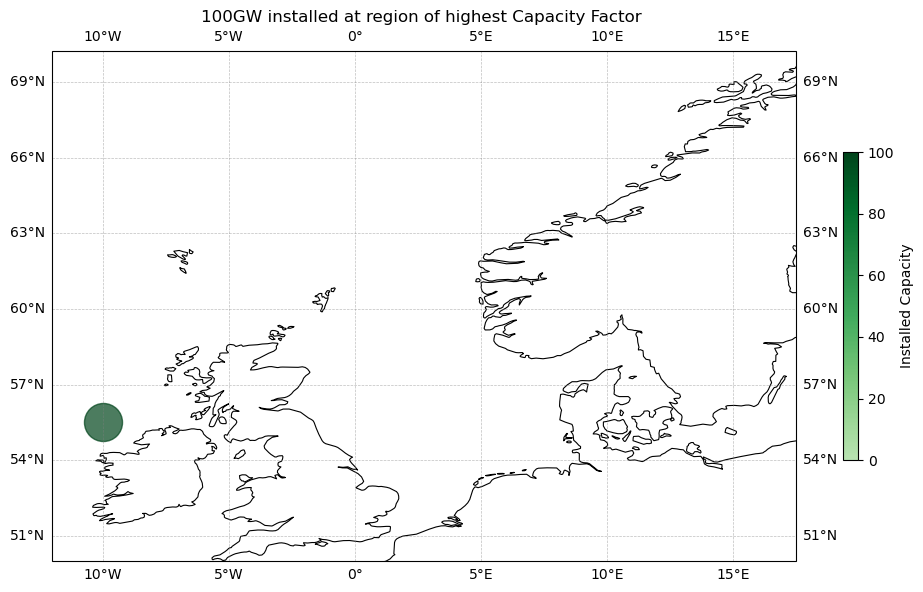

In [43]:
coordinates_1 = [ 
    (55.5, -10.00, 100),# (latitude, longitude, weight)
    (77, -10.00, 0)
]

# Extract weights
weights = [w for _, _, w in coordinates_1]
# Normalize weights
norm = plt.Normalize(min(weights), max(weights))
# Colormap
cmap = plt.cm.get_cmap('Greens')
# Adjust the colormap so that the lowest weight corresponds to a lighter shade of green
new_colors = cmap(np.linspace(0.3, 1, cmap.N))
cmap = plt.cm.colors.ListedColormap(new_colors)

# Create a map with coastlines and wind turbine locations overlay
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([-12, 17.5, 50, 70])

# Add coastlines with the cartopy.feature module
ax.add_feature(cfeature.COASTLINE, linewidth=0.8, edgecolor='black')
ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')

# Plot circles at the turbine locations with size based on weight and color based on weight
for lat, lon, weight in coordinates_1:
    ax.scatter(lon, lat, s=750, color=cmap(norm(weight)), alpha=0.7, transform=ccrs.PlateCarree())

# Create a colorbar
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', shrink=0.5)
cbar.set_label('Installed Capacity')

# Set the title
plt.title('100GW installed at region of highest Capacity Factor ')
plt.grid()

# Show the plot
plt.show()


if were were to install 100GW of wind capacity in total across the 5 different most optimal locations would it A) be best to implement 20GW of wind power at each point OR B) divide the 100GW of installed capacity acording to the weight of each location. 

#  A - 20GW of installed power per location

An area of 0.25 by 0.25 can possess on average 358 Turbines, which using the 8.3MW turbine, results in a installed capacity of 2.9714GW, therefore, for a 20GW of installed power at each region, each region would need to have 2410 turbines 

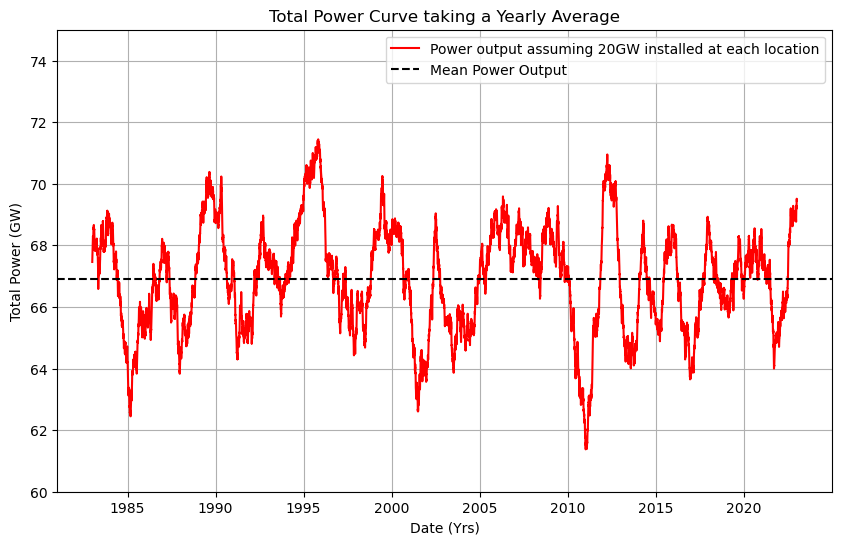

1.7187131778521536
66.89043854612493


In [9]:
############20GW installed at each location - case where all data is used


# Define the coordinates for the first set of turbines
coordinates_1 = [ 
    (64.75, -11.00),
    (61.25, -1.75),
    (66.75, 3.75),
    (54.25, 0.00),
    (54.25, -11.00)
]


# Initialize a variable to store the sum of power curves for the first set of turbines
total_power_curve1 = 0

# Define the number of contributions from each location
num_contributions = 2409

# Loop through all coordinates and add the power curves together for the first set of turbines
for latitude, longitude in coordinates_1:
    power_ds_subset = ds.sel(latitude=latitude, longitude=longitude)['power']
    total_power_curve1 += power_ds_subset / (1000 * 1000) * num_contributions  # Converting to GW and multiplying by num_contributions

# Calculate the rolling average for the total power curve for the first set of turbines
rolling_avg_total1 = total_power_curve1.rolling(time=8760).mean()

# Calculate the mean y value
mean_y_value = rolling_avg_total1.mean().values

# Plotting the total power curve and its rolling average for the first set of turbines
plt.figure(figsize=(10, 6))

plt.plot(rolling_avg_total1.time, rolling_avg_total1, color='red', label='Power output assuming 20GW installed at each location')
plt.axhline(y=mean_y_value, linestyle='--', color='black', label='Mean Power Output')
plt.title('Total Power Curve taking a Yearly Average')
plt.xlabel('Date (Yrs)')
plt.ylabel('Total Power (GW)')
plt.ylim(60,75)
plt.legend()
plt.grid(True)
plt.show()

# Measure the standard deviation for the second set of turbines
std_deviation1 = rolling_avg_total1.std().compute().item()  # <-- Compute the standard deviation
print(std_deviation1)
print(mean_y_value)

ValueError: x and y must have same first dimension, but have shapes (359400,) and (360,)

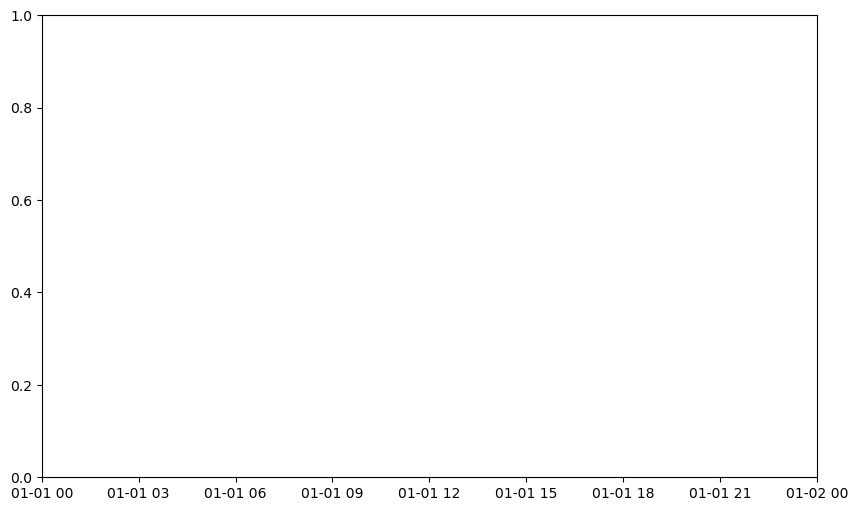

In [10]:
############20GW installed at each location - case where all data is used


# Define the coordinates for the first set of turbines
coordinates_1 = [ 
    (64.75, -11.00),
    (61.25, -1.75),
    (66.75, 3.75),
    (54.25, 0.00),
    (54.25, -11.00)
]


# Initialize a variable to store the sum of power curves for the first set of turbines
total_power_curved1 = 0

# Define the number of contributions from each location
num_contributions = 2409

# Loop through all coordinates and add the power curves together for the first set of turbines
for latitude, longitude in coordinates_1:
    power_ds_subset = ds.sel(latitude=latitude, longitude=longitude,time=slice('2021-02-24', '2021-03-10'))['power']
    total_power_curved1 += power_ds_subset / (1000 * 1000) * num_contributions  # Converting to GW and multiplying by num_contributions

# Calculate the rolling average for the total power curve for the first set of turbines
rolling_avg_totald1 = total_power_curved1.rolling(time=1).mean()

# Calculate the mean y value
mean_y_value = rolling_avg_totald1.mean().values

# Plotting the total power curve and its rolling average for the first set of turbines
plt.figure(figsize=(10, 6))

plt.plot(rolling_avg_total1.time, rolling_avg_totald1, color='red', label='Power output assuming 20GW installed at each location')
plt.axhline(y=mean_y_value, linestyle='--', color='black', label='Mean Power Output')
plt.title('Total Power Curve taking a Yearly Average')
plt.xlabel('Date (Yrs)')
plt.ylabel('Total Power (GW)')

plt.legend()
plt.grid(True)
plt.show()


In [ ]:
############20GW installed at each location - case where only offshore data is used.


# Define the coordinates for the first set of turbines
coordinates_2 = [ 
    (64.75, -11.00),
    (61.25, -1.75),
    (66.75, 3.75),
    (66.75, -1.75),
    (56.0, -11.00)
]


# Initialize a variable to store the sum of power curves for the first set of turbines
total_power_curve2 = 0

# Define the number of contributions from each location
num_contributions = 2410

# Loop through all coordinates and add the power curves together for the first set of turbines
for latitude, longitude in coordinates_2:
    power_ds_subset = ds.sel(latitude=latitude, longitude=longitude)['power']
    total_power_curve2 += power_ds_subset / (1000 * 1000) * num_contributions  # Converting to GW and multiplying by num_contributions

# Calculate the rolling average for the total power curve for the first set of turbines
rolling_avg_total2 = total_power_curve2.rolling(time=8760).mean()

# Calculate the mean y value
mean_y_value2 = rolling_avg_total2.mean().values

# Plotting the total power curve and its rolling average for the first set of turbines
plt.figure(figsize=(10, 6))

plt.plot(rolling_avg_total2.time, rolling_avg_total2, color='red', label='Rolling Average')
plt.axhline(y=mean_y_value2, linestyle='--', color='black', label='Mean')
plt.title('Total Power Curve taking a Yearly Average')
plt.xlabel("Date")
plt.ylabel('Total Power (GW)')
plt.legend()
plt.ylim(60,75)
plt.grid(True)
plt.show()


# Measure the standard deviation for the second set of turbines
std_deviation2 = rolling_avg_total2.std().compute().item()  # <-- Compute the standard deviation
print(std_deviation2)

In [ ]:
plt.figure(figsize=(10, 6))


plt.plot(rolling_avg_total1.time, rolling_avg_total1, color='red', label='Rolling Average')
plt.axhline(y=mean_y_value, linestyle='--', color='black', label='Mean')
plt.plot(rolling_avg_total2.time, rolling_avg_total2, color='blue', label='Rolling Average')
plt.axhline(y=mean_y_value2, linestyle='--', color='orange', label='Mean')
plt.title('Total Power Curve taking a Yearly Average')
plt.xlabel('Time')
plt.ylabel('Total Power (GW)')
plt.ylim(60,75)
plt.legend()
plt.grid(True)
plt.show()

# B  

I now want to consider the situation where the 100GW of installed capacity is dispurted in the 5 locations depending on the specifc weight they hold. This will be different for the case where all data is considered and where only offshore data is considered. In total to have a 100GW installed capacity, we need to us 12048 wind turbines. 

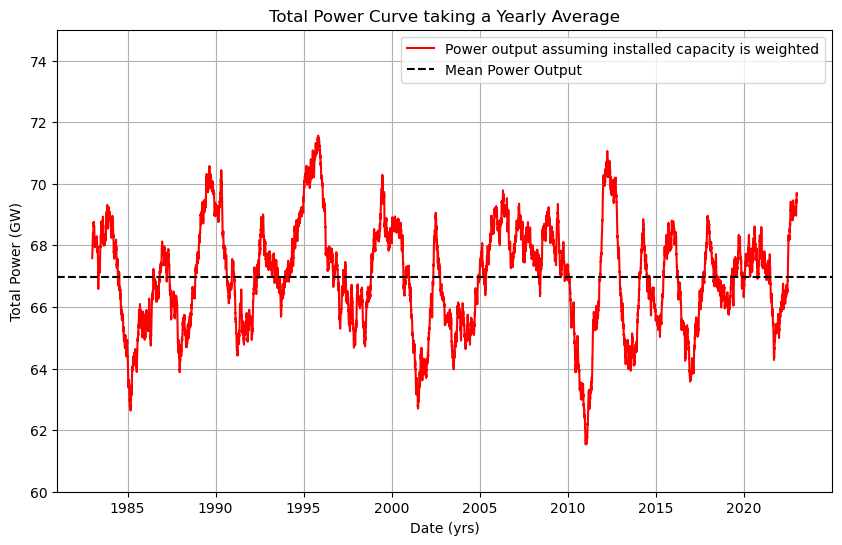

1.7230250042732416
66.97463907411993


In [12]:
############ Amount installed depends on weight - case where all data is used


#(64.75, -11.00) = 21.21% = 2556 turbines = 21.21GW
#(61.25, -1.75) = 21.21% = 2556 turbines = 21.21GW 
#(66.75, 3.75) = 21.21% = 2556 turbines = 21.21GW
#(54.25, 0.00) = 18.18% = 2190 turbines = 18.18GW
#(54.25, -11.00) = 18.18% = 2190 turbines = 18.18GW

# Define the coordinates for the first set of turbines along with their percentages
coordinates_3 = { 
    (64.75, -11.00): 21.21,  # (latitude, longitude): percentage
    (61.25, -1.75): 21.21,
    (66.75, 3.75): 21.21,
    (54.25, 0.00): 18.18,
    (54.25, -11.00): 18.18
}



# Initialize a variable to store the sum of power curves for the first set of turbines
total_power_curve3 = 0

# Define the total number of turbines
total_turbines = 12048

# Loop through all coordinates and add the power curves together for the first set of turbines
for (latitude, longitude), percentage in coordinates_3.items():
    power_ds_subset = ds.sel(latitude=latitude, longitude=longitude)['power']
    num_turbines = int(total_turbines * (percentage / 100)) 
    total_power_curve3 += power_ds_subset / (1000 * 1000) * num_turbines  # Converting to GW and multiplying by the number of turbines

# Calculate the rolling average for the total power curve for the first set of turbines
rolling_avg_total3 = total_power_curve3.rolling(time=8760).mean()

# Calculate the mean y value
mean_y_value3 = rolling_avg_total3.mean().values

# Plotting the total power curve and its rolling average for the first set of turbines
plt.figure(figsize=(10, 6))

plt.plot(rolling_avg_total3.time, rolling_avg_total3, color='red', label='Power output assuming installed capacity is weighted')
plt.axhline(y=mean_y_value3, linestyle='--', color='black', label='Mean Power Output')
plt.title('Total Power Curve taking a Yearly Average')
plt.xlabel('Date (yrs)')
plt.ylabel('Total Power (GW)')
plt.ylim(60,75)
plt.legend()
plt.grid(True)
plt.show()

# Measure the standard deviation for the second set of turbines
std_deviation3 = rolling_avg_total3.std().compute().item()  # <-- Compute the standard deviation
print(std_deviation3)
print(mean_y_value3)


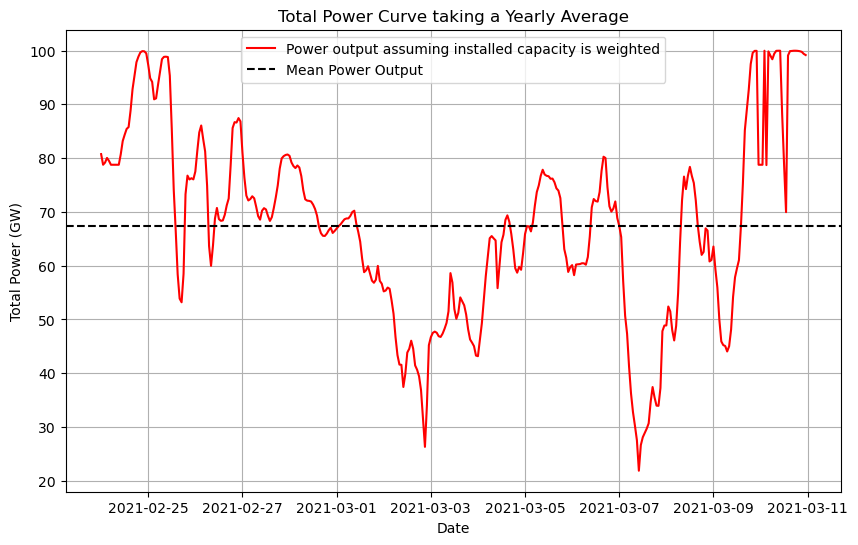

In [19]:
############ Amount installed depends on weight - case where all data is used


#(64.75, -11.00) = 21.21% = 2556 turbines = 21.21GW
#(61.25, -1.75) = 21.21% = 2556 turbines = 21.21GW 
#(66.75, 3.75) = 21.21% = 2556 turbines = 21.21GW
#(54.25, 0.00) = 18.18% = 2190 turbines = 18.18GW
#(54.25, -11.00) = 18.18% = 2190 turbines = 18.18GW

# Define the coordinates for the first set of turbines along with their percentages
coordinates_3 = { 
    (64.75, -11.00): 21.21,  # (latitude, longitude): percentage
    (61.25, -1.75): 21.21,
    (66.75, 3.75): 21.21,
    (54.25, 0.00): 18.18,
    (54.25, -11.00): 18.18
}



# Initialize a variable to store the sum of power curves for the first set of turbines
total_power_curved3 = 0

# Define the total number of turbines
total_turbines = 12048

# Loop through all coordinates and add the power curves together for the first set of turbines
for (latitude, longitude), percentage in coordinates_3.items():
    power_ds_subset = ds.sel(latitude=latitude, longitude=longitude,time=slice('2021-02-24', '2021-03-10'))['power']
    num_turbines = int(total_turbines * (percentage / 100)) 
    total_power_curved3 += power_ds_subset / (1000 * 1000) * num_turbines  # Converting to GW and multiplying by the number of turbines

# Calculate the rolling average for the total power curve for the first set of turbines
rolling_avg_totald3 = total_power_curved3.rolling(time=1).mean()

# Calculate the mean y value
mean_y_value3 = rolling_avg_totald3.mean().values

# Plotting the total power curve and its rolling average for the first set of turbines
plt.figure(figsize=(10, 6))

# Use the time coordinate from rolling_avg_totald3 for x-axis
plt.plot(rolling_avg_totald3.time, rolling_avg_totald3, color='red', label='Power output assuming installed capacity is weighted')

# Use the mean_y_value3 for the y-axis
plt.axhline(y=mean_y_value3, linestyle='--', color='black', label='Mean Power Output')
plt.title('Total Power Curve taking a Yearly Average')
plt.xlabel('Date')
plt.ylabel('Total Power (GW)')

plt.legend()
plt.grid(True)
plt.show()


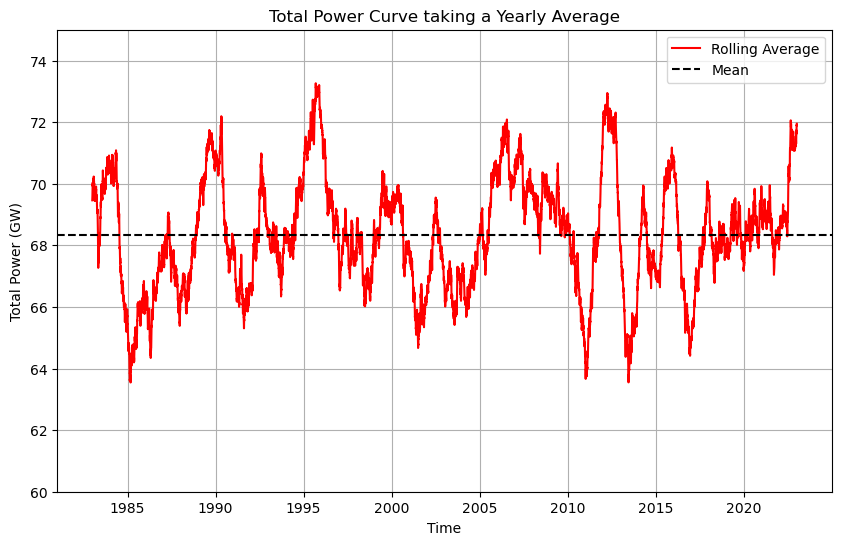

1.8283647714347349


In [19]:
############ Amount installed depends on weight - case where all only offshore data is used 


#(64.75, -11.00) = 21.875 = 2635
#(61.25, -1.75) = 21.875 = 2635
#(66.75, 3.75) = 21.875 = 2635 
#(66.75, -1.75) = 15.625 = 1883
#(56.0, -11.00) = 18.75 = 2260


coordinates_4 = { 
    (64.75, -11.00): 21.875,  # (latitude, longitude, weight)
    (61.25, -1.75): 21.875, #21.875
    (66.75, 3.75): 21.875,
    (66.75, -1.75): 15.625,
    (56.0, -11.00): 18.75 #18.75

}


# Initialize a variable to store the sum of power curves for the first set of turbines
total_power_curve4 = 0

# Define the total number of turbines
total_turbines = 12048 #8.3MW X 12048 = 100GW installed

# Loop through all coordinates and add the power curves together for the first set of turbines
for (latitude, longitude), percentage in coordinates_4.items():
    power_ds_subset = ds.sel(latitude=latitude, longitude=longitude)['power']
    num_turbines = int(total_turbines * (percentage / 100)) 
    total_power_curve4 += power_ds_subset / (1000 * 1000) * num_turbines  # Converting to GW and multiplying by the number of turbines

# Calculate the rolling average for the total power curve for the first set of turbines
rolling_avg_total4 = total_power_curve4.rolling(time=8760).mean()

# Calculate the mean y value
mean_y_value4 = rolling_avg_total4.mean().values

# Plotting the total power curve and its rolling average for the first set of turbines
plt.figure(figsize=(10, 6))

plt.plot(rolling_avg_total4.time, rolling_avg_total4, color='red', label='Rolling Average')
plt.axhline(y=mean_y_value4, linestyle='--', color='black', label='Mean')
plt.title('Total Power Curve taking a Yearly Average')
plt.xlabel('Time')
plt.ylabel('Total Power (GW)')
plt.ylim(60,75)
plt.legend()
plt.grid(True)
plt.show()

# Measure the standard deviation for the second set of turbines
std_deviation4 = rolling_avg_total4.std().compute().item()  # <-- Compute the standard deviation
print(std_deviation4)



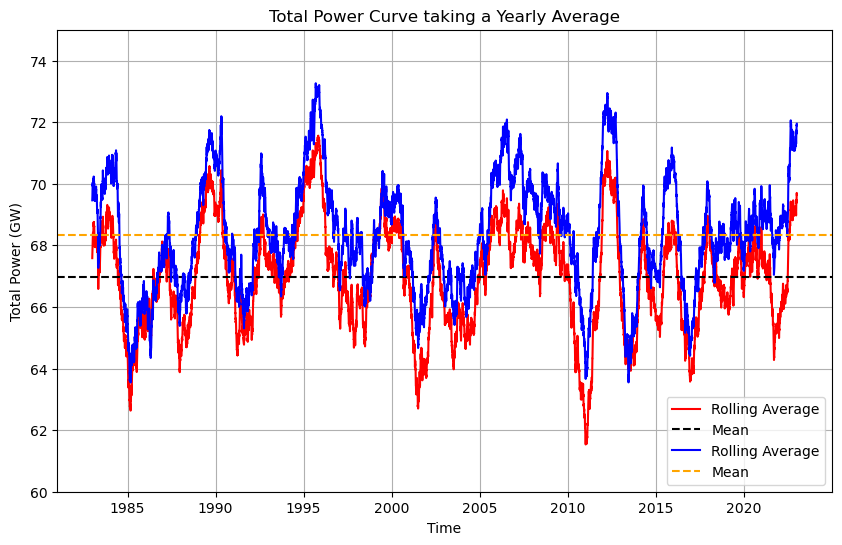

In [20]:
plt.figure(figsize=(10, 6))


plt.plot(rolling_avg_total3.time, rolling_avg_total3, color='red', label='Rolling Average')
plt.axhline(y=mean_y_value3, linestyle='--', color='black', label='Mean')
plt.plot(rolling_avg_total4.time, rolling_avg_total4, color='blue', label='Rolling Average')
plt.axhline(y=mean_y_value4, linestyle='--', color='orange', label='Mean')
plt.title('Total Power Curve taking a Yearly Average')
plt.xlabel('Time')
plt.ylabel('Total Power (GW)')
plt.ylim(60,75)
plt.legend()
plt.grid(True)
plt.show()

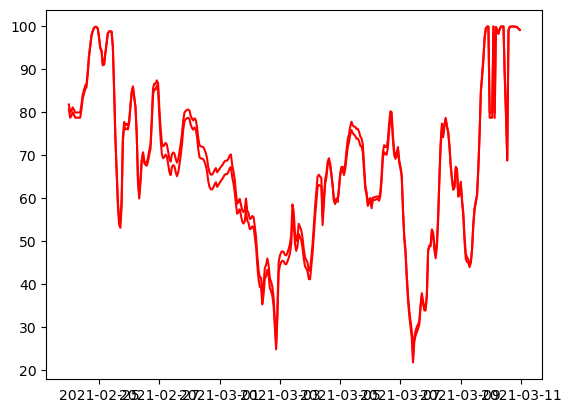

In [22]:
# Use the time coordinate from rolling_avg_totald3 for x-axis
plt.figure()

plt.plot(rolling_avg_totald3.time, rolling_avg_totald3, color='red', label='Power output assuming installed capacity is weighted')
plt.plot(rolling_avg_total1.time, rolling_avg_totald1, color='red', label='Power output assuming 20GW installed at each location')

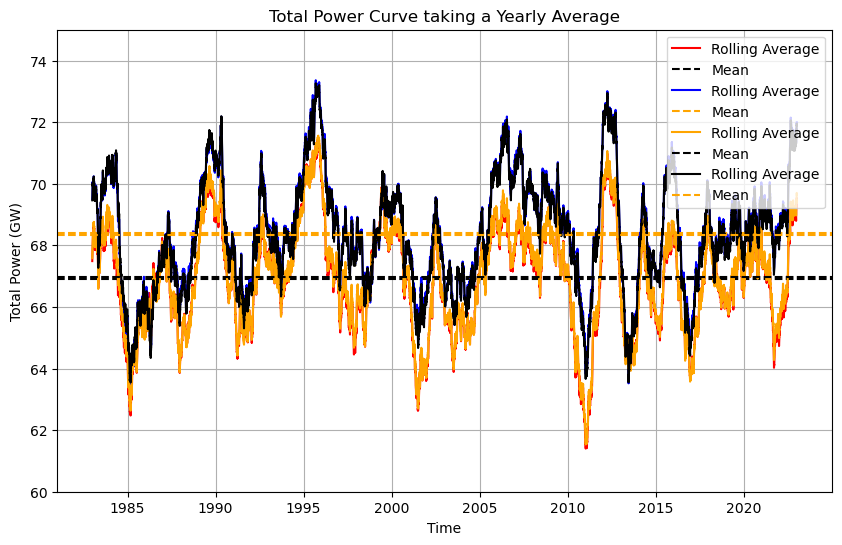

In [21]:
plt.figure(figsize=(10, 6))

plt.plot(rolling_avg_total1.time, rolling_avg_total1, color='red', label='Rolling Average')
plt.axhline(y=mean_y_value, linestyle='--', color='black', label='Mean')
plt.plot(rolling_avg_total2.time, rolling_avg_total2, color='blue', label='Rolling Average')
plt.axhline(y=mean_y_value2, linestyle='--', color='orange', label='Mean')
plt.plot(rolling_avg_total3.time, rolling_avg_total3, color='orange', label='Rolling Average')
plt.axhline(y=mean_y_value3, linestyle='--', color='black', label='Mean')
plt.plot(rolling_avg_total4.time, rolling_avg_total4, color='black', label='Rolling Average')
plt.axhline(y=mean_y_value4, linestyle='--', color='orange', label='Mean')
plt.title('Total Power Curve taking a Yearly Average')
plt.xlabel('Time')
plt.ylabel('Total Power (GW)')
plt.ylim(60,75)
plt.legend()
plt.grid(True)
plt.show()


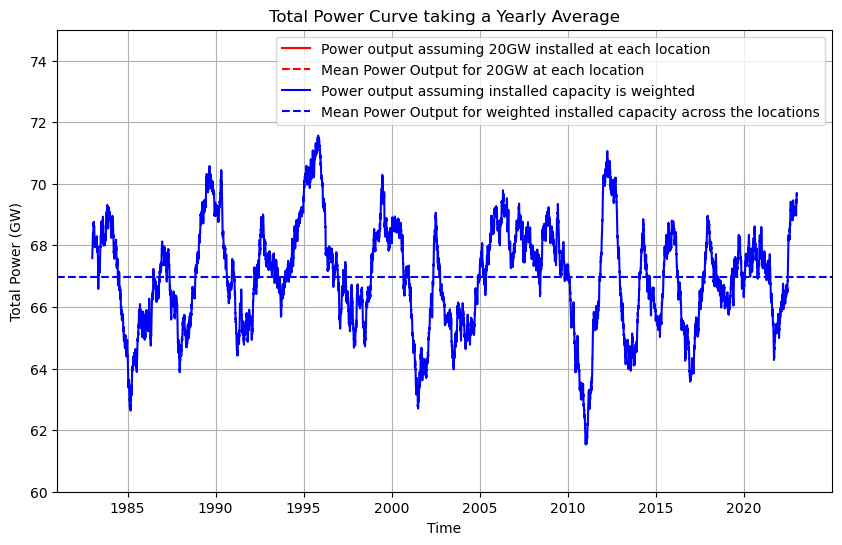

In [31]:
plt.figure(figsize=(10, 6))


plt.plot(rolling_avg_total1.time, rolling_avg_total1, color='red', label='Power output assuming 20GW installed at each location')
plt.axhline(y=mean_y_value, linestyle='--', color='red', label='Mean Power Output for 20GW at each location')
plt.plot(rolling_avg_total3.time, rolling_avg_total3, color='blue', label='Power output assuming installed capacity is weighted')
plt.axhline(y=mean_y_value3, linestyle='--', color='blue', label='Mean Power Output for weighted installed capacity across the locations')
plt.title('Total Power Curve taking a Yearly Average')
plt.xlabel('Time')
plt.ylabel('Total Power (GW)')
plt.ylim(60,75)
plt.legend()
plt.grid(True)
plt.show()

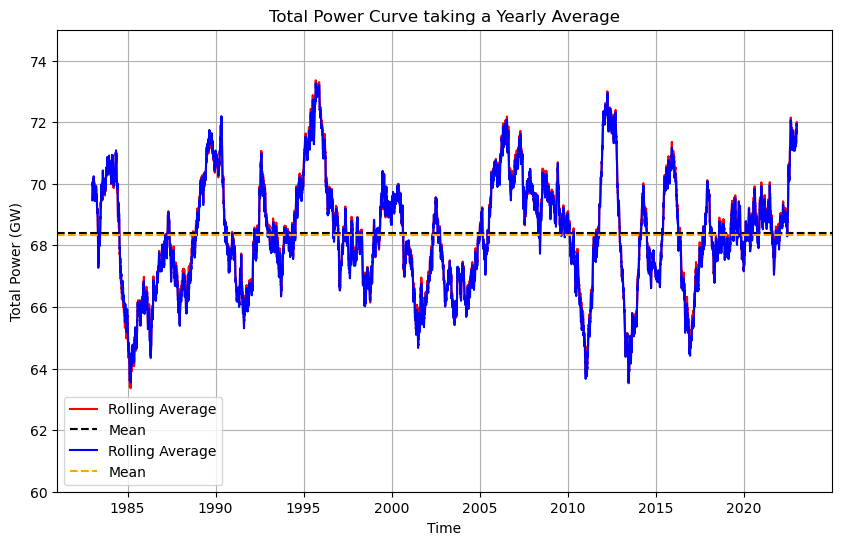

In [23]:
plt.figure(figsize=(10, 6))


plt.plot(rolling_avg_total2.time, rolling_avg_total2, color='red', label='Rolling Average')
plt.axhline(y=mean_y_value2, linestyle='--', color='black', label='Mean')
plt.plot(rolling_avg_total4.time, rolling_avg_total4, color='blue', label='Rolling Average')
plt.axhline(y=mean_y_value4, linestyle='--', color='orange', label='Mean')
plt.title('Total Power Curve taking a Yearly Average')
plt.xlabel('Time')
plt.ylabel('Total Power (GW)')
plt.ylim(60,75)
plt.legend()
plt.grid(True)
plt.show()

In [24]:
#######################

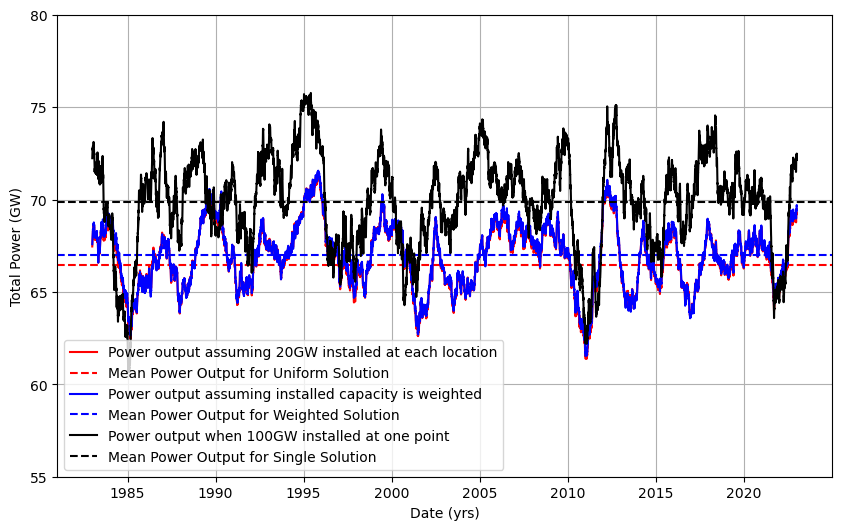

2.5570724503368725
69.85612465470273


In [13]:
# Define the coordinates for the first set of turbines along with their percentages
coordinates_7 = { 
    (55.50, -10.00): 100,  # (latitude, longitude): percentage

}



# Initialize a variable to store the sum of power curves for the first set of turbines
total_power_curve7 = 0

# Define the total number of turbines
total_turbines = 12048

# Loop through all coordinates and add the power curves together for the first set of turbines
for (latitude, longitude), percentage in coordinates_7.items():
    power_ds_subset = ds.sel(latitude=latitude, longitude=longitude)['power']
    num_turbines = int(total_turbines * (percentage / 100)) 
    total_power_curve7 += power_ds_subset / (1000 * 1000) * num_turbines  # Converting to GW and multiplying by the number of turbines

# Calculate the rolling average for the total power curve for the first set of turbines
rolling_avg_total7 = total_power_curve7.rolling(time=8760).mean()

# Calculate the mean y value
mean_y_value7 = rolling_avg_total7.mean().values

# Plotting the total power curve and its rolling average for the first set of turbines
plt.figure(figsize=(10, 6))

plt.plot(rolling_avg_total1.time, rolling_avg_total1, color='red', label='Power output assuming 20GW installed at each location')
plt.axhline(y=mean_y_value, linestyle='--', color='red', label='Mean Power Output for Uniform Solution')
plt.plot(rolling_avg_total3.time, rolling_avg_total3, color='blue', label='Power output assuming installed capacity is weighted')
plt.axhline(y=mean_y_value3, linestyle='--', color='blue', label='Mean Power Output for Weighted Solution')
plt.plot(rolling_avg_total7.time, rolling_avg_total7, color='black', label='Power output when 100GW installed at one point')
plt.axhline(y=mean_y_value7, linestyle='--', color='black', label='Mean Power Output for Single Solution')
plt.xlabel('Date (yrs)')
plt.ylabel('Total Power (GW)')
plt.ylim(55,80)
plt.legend()
plt.grid(True)
plt.show()

# Measure the standard deviation for the second set of turbines
std_deviation7 = rolling_avg_total7.std().compute().item()  # <-- Compute the standard deviation
print(std_deviation7)
print(mean_y_value7)

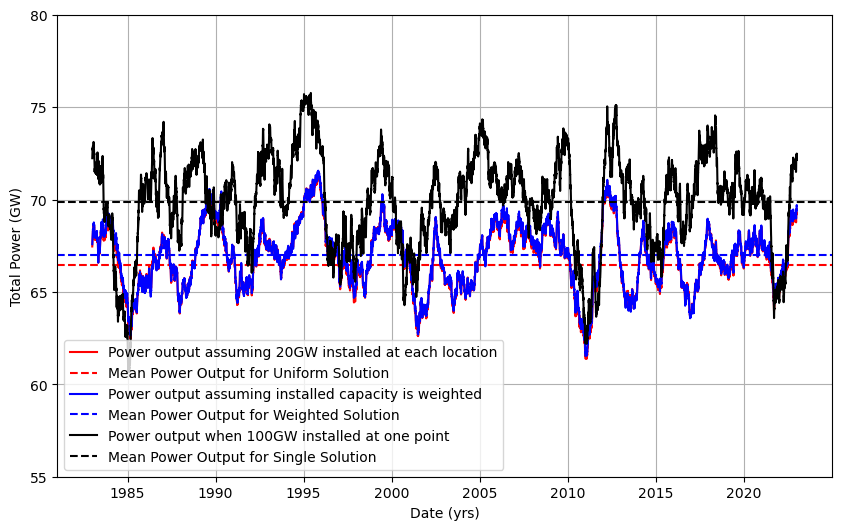

In [15]:
plt.figure(figsize=(10, 6))

plt.plot(rolling_avg_total1.time, rolling_avg_total1, color='red', label='Power output assuming 20GW installed at each location')
plt.axhline(y=mean_y_value, linestyle='--', color='red', label='Mean Power Output for Uniform Solution')
plt.plot(rolling_avg_total3.time, rolling_avg_total3, color='blue', label='Power output assuming installed capacity is weighted')
plt.axhline(y=mean_y_value3, linestyle='--', color='blue', label='Mean Power Output for Weighted Solution')
plt.plot(rolling_avg_total7.time, rolling_avg_total7, color='black', label='Power output when 100GW installed at one point')
plt.axhline(y=mean_y_value7, linestyle='--', color='black', label='Mean Power Output for Single Solution')


plt.xlabel('Date (yrs)')
plt.ylabel('Total Power (GW)')
plt.ylim(55, 80)
plt.legend()
plt.grid(True)
plt.show()


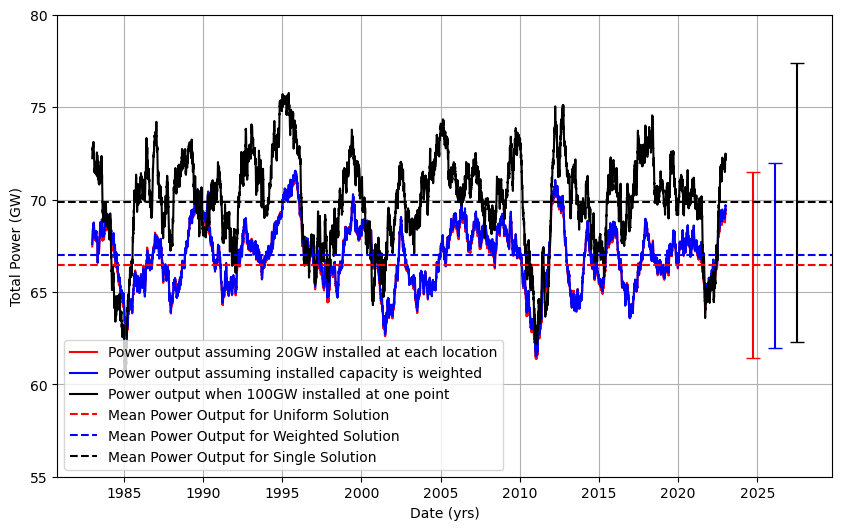

In [44]:
import matplotlib.pyplot as plt

# Define the variance or standard deviation for each dataset
variance_total1 = rolling_avg_total1.var()  # Assuming rolling_avg_total1 is a pandas DataFrame
variance_total3 = rolling_avg_total3.var()  # Assuming rolling_avg_total3 is a pandas DataFrame
variance_total7 = rolling_avg_total7.var()  # Assuming rolling_avg_total7 is a pandas DataFrame

# Define the width of the error bars (optional)
error_bar_width = 1

r1 = (71.44091195630989 - 61.37555380473958)/2
r2 = (71.56027346382237 - 61.534306566691725)/2
r3 = (75.76688382533814 - 60.660261027126076)/2


# Plotting the lines
plt.figure(figsize=(10, 6))

# Plotting the lines with error bars representing variance
plt.plot(rolling_avg_total1.time, rolling_avg_total1, color='red', label='Power output assuming 20GW installed at each location')
plt.errorbar(20000,mean_y_value , yerr=r1, fmt='none', ecolor='red', capsize=5, barsabove=True)


plt.plot(rolling_avg_total3.time, rolling_avg_total3, color='blue', label='Power output assuming installed capacity is weighted')
plt.errorbar(20500, mean_y_value3, yerr=r2, fmt='none', ecolor='blue', capsize=5, barsabove=True)


plt.plot(rolling_avg_total7.time, rolling_avg_total7, color='black', label='Power output when 100GW installed at one point')
plt.errorbar(21000, mean_y_value7, yerr=r3, fmt='none', ecolor='black', capsize=5, barsabove=True)

# Plotting the mean lines
plt.axhline(y=mean_y_value, linestyle='--', color='red', label='Mean Power Output for Uniform Solution')
plt.axhline(y=mean_y_value3, linestyle='--', color='blue', label='Mean Power Output for Weighted Solution')
plt.axhline(y=mean_y_value7, linestyle='--', color='black', label='Mean Power Output for Single Solution')

# Labeling the axes and setting limits
plt.xlabel('Date (yrs)')
plt.ylabel('Total Power (GW)')
plt.ylim(55, 80)

# Adding legend and grid
plt.legend()
plt.grid(True)

# Showing the plot
plt.show()


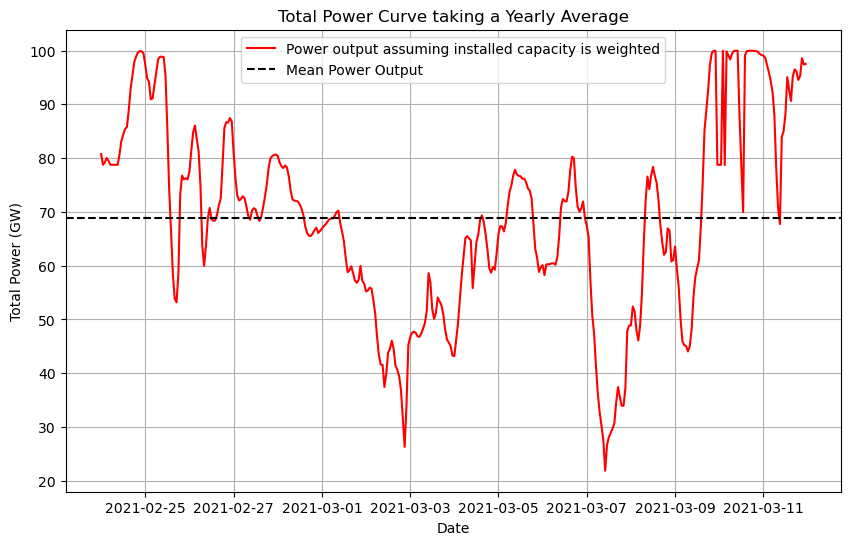

In [67]:
############ Amount installed depends on weight - case where all data is used


#(64.75, -11.00) = 21.21% = 2556 turbines = 21.21GW
#(61.25, -1.75) = 21.21% = 2556 turbines = 21.21GW 
#(66.75, 3.75) = 21.21% = 2556 turbines = 21.21GW
#(54.25, 0.00) = 18.18% = 2190 turbines = 18.18GW
#(54.25, -11.00) = 18.18% = 2190 turbines = 18.18GW

# Define the coordinates for the first set of turbines along with their percentages
coordinates_3 = { 
    (64.75, -11.00): 21.21,  # (latitude, longitude): percentage
    (61.25, -1.75): 21.21,
    (66.75, 3.75): 21.21,
    (54.25, 0.00): 18.18,
    (54.25, -11.00): 18.18
}



# Initialize a variable to store the sum of power curves for the first set of turbines
total_power_curved3 = 0

# Define the total number of turbines
total_turbines = 12048

# Loop through all coordinates and add the power curves together for the first set of turbines
for (latitude, longitude), percentage in coordinates_3.items():
    power_ds_subset = ds.sel(latitude=latitude, longitude=longitude,time=slice('2021-02-24', '2021-03-11'))['power']
    num_turbines = int(total_turbines * (percentage / 100)) 
    total_power_curved3 += power_ds_subset / (1000 * 1000) * num_turbines  # Converting to GW and multiplying by the number of turbines

# Calculate the rolling average for the total power curve for the first set of turbines
rolling_avg_totald3 = total_power_curved3.rolling(time=1).mean()

# Calculate the mean y value
mean_y_value3 = rolling_avg_totald3.mean().values

# Plotting the total power curve and its rolling average for the first set of turbines
plt.figure(figsize=(10, 6))

# Use the time coordinate from rolling_avg_totald3 for x-axis
plt.plot(rolling_avg_totald3.time, rolling_avg_totald3, color='red', label='Power output assuming installed capacity is weighted')

# Use the mean_y_value3 for the y-axis
plt.axhline(y=mean_y_value3, linestyle='--', color='black', label='Mean Power Output')
plt.title('Total Power Curve taking a Yearly Average')
plt.xlabel('Date')
plt.ylabel('Total Power (GW)')

plt.legend()
plt.grid(True)
plt.show()



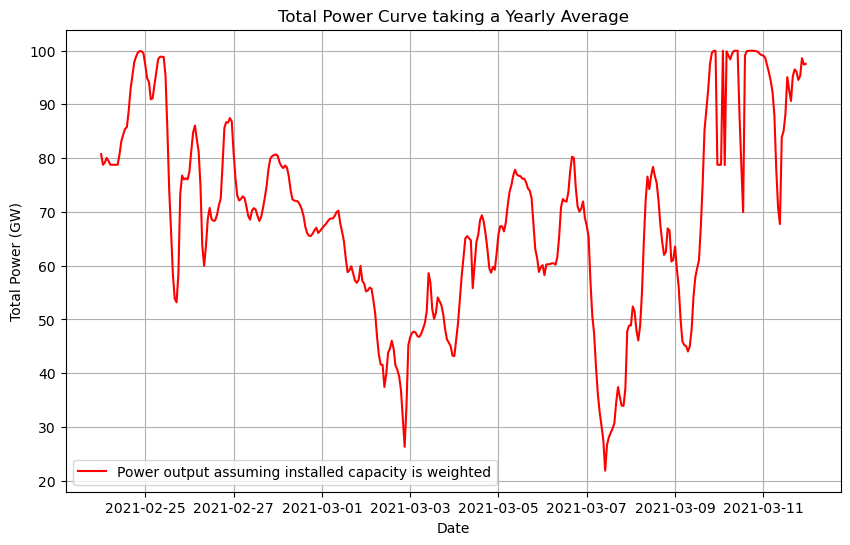

In [68]:
############ Amount installed depends on weight - case where all data is used


#(64.75, -11.00) = 21.21% = 2556 turbines = 21.21GW
#(61.25, -1.75) = 21.21% = 2556 turbines = 21.21GW 
#(66.75, 3.75) = 21.21% = 2556 turbines = 21.21GW
#(54.25, 0.00) = 18.18% = 2190 turbines = 18.18GW
#(54.25, -11.00) = 18.18% = 2190 turbines = 18.18GW

# Define the coordinates for the first set of turbines along with their percentages
coordinates_7 = { 
    (55.00, -10.00): 100,  # (latitude, longitude): percentag
}



# Initialize a variable to store the sum of power curves for the first set of turbines
total_power_curved7 = 0

# Define the total number of turbines
total_turbines = 12048

# Loop through all coordinates and add the power curves together for the first set of turbines
for (latitude, longitude), percentage in coordinates_7.items():
    power_ds_subset = ds.sel(latitude=latitude, longitude=longitude,time=slice('2021-02-24', '2021-03-11'))['power']
    num_turbines = int(total_turbines * (percentage / 100)) 
    total_power_curved7 += power_ds_subset / (1000 * 1000) * num_turbines  # Converting to GW and multiplying by the number of turbines

# Calculate the rolling average for the total power curve for the first set of turbines
rolling_avg_totald7 = total_power_curved7.rolling(time=1).mean()

# Calculate the mean y value
mean_y_value7 = rolling_avg_totald7.mean().values

# Plotting the total power curve and its rolling average for the first set of turbines
plt.figure(figsize=(10, 6))

# Use the time coordinate from rolling_avg_totald3 for x-axis
plt.plot(rolling_avg_totald7.time, rolling_avg_totald3, color='red', label='Power output assuming installed capacity is weighted')

# Use the mean_y_value3 for the y-axis
plt.title('Total Power Curve taking a Yearly Average')
plt.xlabel('Date')
plt.ylabel('Total Power (GW)')

plt.legend()
plt.grid(True)
plt.show()

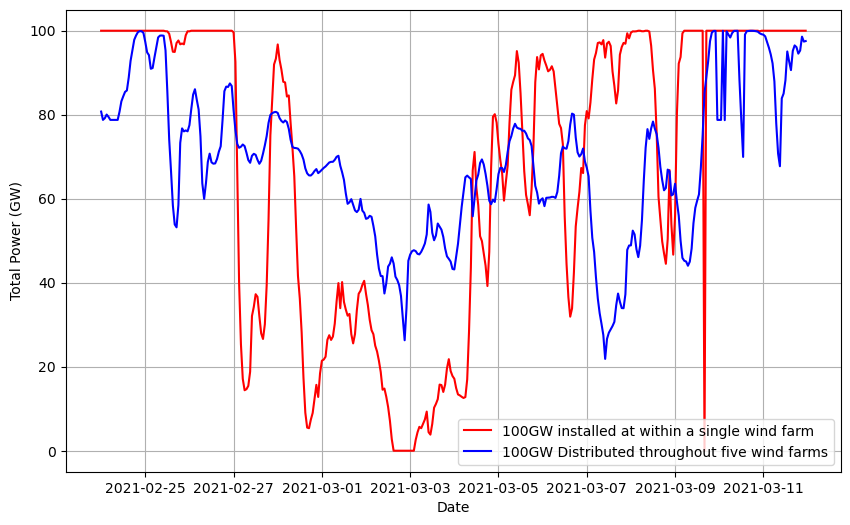

In [71]:
# Plotting the total power curve and its rolling average for the first set of turbines
plt.figure(figsize=(10, 6))

# Use the time coordinate from rolling_avg_totald3 for x-axis
plt.plot(rolling_avg_totald7.time, rolling_avg_totald7, color='red', label='100GW installed at within a single wind farm')
# Use the time coordinate from rolling_avg_totald3 for x-axis
plt.plot(rolling_avg_totald3.time, rolling_avg_totald3, color='blue', label='100GW Distributed throughout five wind farms')


# Use the mean_y_value3 for the y-axis
plt.xlabel('Date')
plt.ylabel('Total Power (GW)')

plt.legend()
plt.grid(True)
plt.show()